# AAAI

0.9900498337491681
Start evaluating
tensor(-678.8810, device='cuda:0')
Step 0: Reward -1.088 
Step 100: Reward -5.585 
Step 200: Reward -27.400 
Start evaluating
Evaluation Average Reward: -8.9686e+02 Time: 3.24s
Step 300: Reward -26.005 
Start evaluating
Evaluation Average Reward: -1.0606e+03 Time: 8.78s
Step 400: Reward -25.054 
Start evaluating
Evaluation Average Reward: -8.6778e+02 Time: 14.43s
Step 500: Reward -25.129 
Start evaluating
Evaluation Average Reward: -8.2291e+02 Time: 20.03s
Step 600: Reward -25.325 
Start evaluating
Evaluation Average Reward: -8.8529e+02 Time: 25.69s
Step 700: Reward -26.101 
Start evaluating
Evaluation Average Reward: -7.6093e+02 Time: 31.22s
Step 800: Reward -25.517 
Start evaluating
Evaluation Average Reward: -7.7115e+02 Time: 36.77s
Step 900: Reward -25.580 
Start evaluating
Evaluation Average Reward: -6.9355e+02 Time: 42.04s
Step 1000: Reward -25.558 
Start evaluating
Evaluation Average Reward: -6.3420e+02 Time: 48.36s
Step 1100: Reward -25.491 


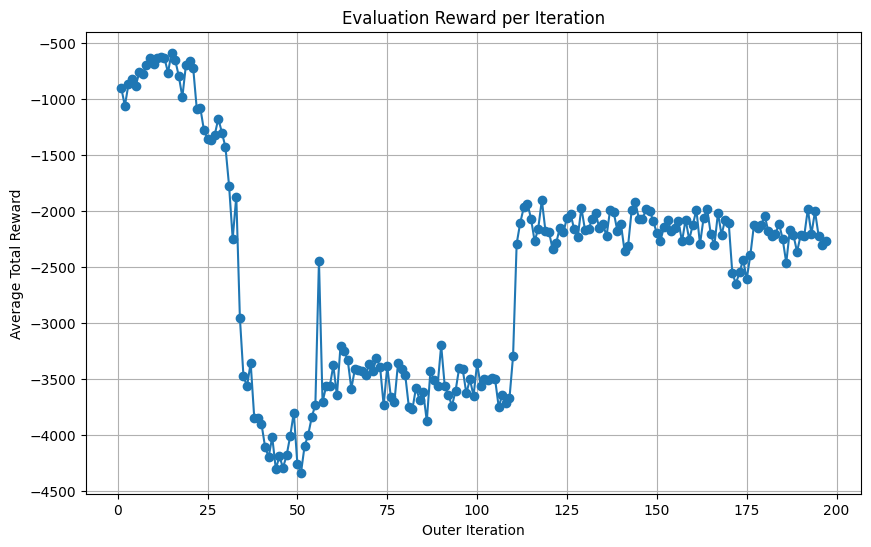

Reward plot saved to results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

# device = "cpu"  # 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B


_sigma = 0.1
# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = _sigma * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 1
# max_u = 10
max_u = 1
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
update_every = 1

start_steps = 200
update_after = 200

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

# device = "cpu"  # 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/test/sac/lqr_5d_sigma_0p1_u[-10,10]_x[-10,10]"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B


_sigma = 0.1
# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = _sigma * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 10
# max_u = 10
max_u = 10
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
update_every = 1

start_steps = 200
update_after = 200

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
eval_x0 = 0
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = eval_x0 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

0.9900498337491681
Start evaluating
tensor(-12824.6484, device='cuda:0')
Step 0: Reward -1.802 
Step 100: Reward -7.292 
Step 200: Reward -257.574 
Start evaluating
Evaluation Average Reward: -1.0660e+04 Time: 4.44s
Step 300: Reward -189.560 
Start evaluating
Evaluation Average Reward: -2.5089e+02 Time: 11.06s
Step 400: Reward -4.587 
Start evaluating
Evaluation Average Reward: -9.5929e+02 Time: 17.65s
Step 500: Reward -569.050 
Start evaluating
Evaluation Average Reward: -8.9833e+01 Time: 23.72s
Step 600: Reward -19.605 
Start evaluating
Evaluation Average Reward: -1.9241e+02 Time: 30.62s
Step 700: Reward -2.356 
Start evaluating
Evaluation Average Reward: -7.3402e+01 Time: 36.41s
Step 800: Reward -728.149 
Start evaluating
Evaluation Average Reward: -1.9722e+02 Time: 42.16s
Step 900: Reward -14.291 
Start evaluating
Evaluation Average Reward: -8.6044e+02 Time: 47.81s
Step 1000: Reward -438.099 
Start evaluating
Evaluation Average Reward: -6.8988e+02 Time: 55.69s
Step 1100: Reward -3.

KeyboardInterrupt: 

# ICLR

### [looping fix]X_0 = 0, sigma 0.1, x_s_ratio = 5, domain [-1, 1] xavier gain None

0.9900498337491681
Start evaluating
tensor(-901.4194, device='cuda:0')
Step 0: Reward -1.389 
Step 100: Reward -16.968 
Step 200: Reward -26.014 
Start evaluating
Evaluation Average Reward: -6.7148e+02 Time: 4.31s
Step 300: Reward -27.923 
Start evaluating
Evaluation Average Reward: -9.3106e+02 Time: 12.57s
Step 400: Reward -25.034 
Start evaluating
Evaluation Average Reward: -9.1848e+02 Time: 21.23s
Step 500: Reward -25.136 
Start evaluating
Evaluation Average Reward: -6.9170e+02 Time: 29.92s
Step 600: Reward -25.653 
Start evaluating
Evaluation Average Reward: -6.9818e+02 Time: 38.82s
Step 700: Reward -25.828 
Start evaluating
Evaluation Average Reward: -1.1116e+03 Time: 46.73s
Step 800: Reward -27.830 
Start evaluating
Evaluation Average Reward: -7.5039e+02 Time: 55.61s
Step 900: Reward -27.044 
Start evaluating
Evaluation Average Reward: -8.4029e+02 Time: 64.60s
Step 1000: Reward -26.600 
Start evaluating
Evaluation Average Reward: -8.2388e+02 Time: 73.51s
Step 1100: Reward -25.841

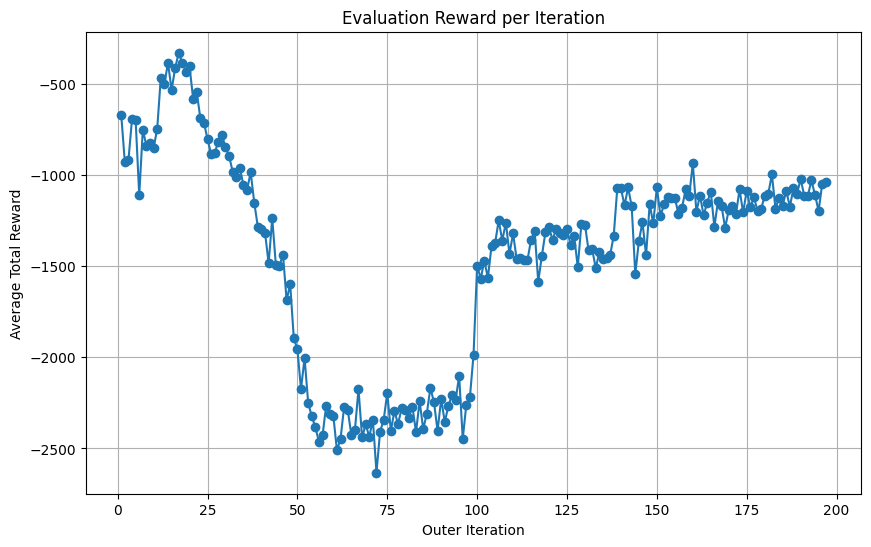

Reward plot saved to results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

# device = "cpu"  # 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B


_sigma = 0.1
# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = _sigma * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 1
# max_u = 10
max_u = 1
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
update_every = 1

start_steps = 200
update_after = 200

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### [looping fix]X_0 = 0, sigma 0.01, x_s_ratio = 5, domain [-1, 1] xavier gain None

0.9900498337491681
Start evaluating
tensor(-948.6966)
Step 0: Reward -2.151 
Step 100: Reward -1.804 
Step 200: Reward -2.180 
Start evaluating
Evaluation Average Reward: -2.1660e+03 Time: 2.45s
Step 300: Reward -26.293 
Start evaluating
Evaluation Average Reward: -1.0232e+03 Time: 6.45s
Step 400: Reward -25.092 
Start evaluating
Evaluation Average Reward: -1.4202e+03 Time: 10.36s
Step 500: Reward -26.324 
Start evaluating
Evaluation Average Reward: -8.2082e+02 Time: 14.46s
Step 600: Reward -26.060 
Start evaluating
Evaluation Average Reward: -9.0378e+02 Time: 18.23s
Step 700: Reward -25.872 
Start evaluating
Evaluation Average Reward: -1.0381e+03 Time: 21.93s
Step 800: Reward -25.124 
Start evaluating
Evaluation Average Reward: -1.2125e+03 Time: 25.86s
Step 900: Reward -25.398 
Start evaluating
Evaluation Average Reward: -1.2805e+03 Time: 29.83s
Step 1000: Reward -25.355 
Start evaluating
Evaluation Average Reward: -1.2459e+03 Time: 33.68s
Step 1100: Reward -25.239 
Start evaluating
E

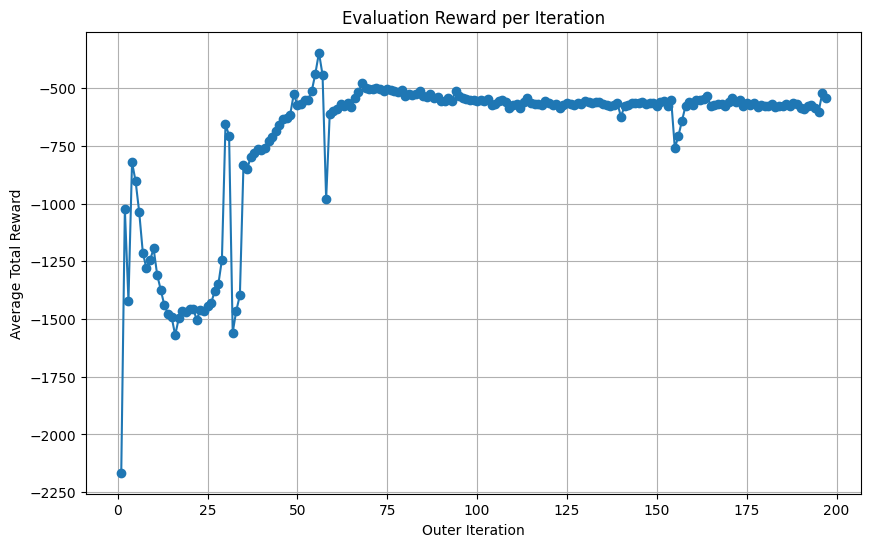

Reward plot saved to results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [52]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B


_sigma = 0.1
# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = _sigma * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 1
# max_u = 10
max_u = 1
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 20000
update_every = 1

start_steps = 200
update_after = 200

plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### [looping fix] X_0 = 0, sigma 0.1, x_s_ratio = 5, domain [-1, 1] xavier gain None

0.9900498337491681
Start evaluating
tensor(-879.1750)
Step 0: Reward -2.808 
Step 100: Reward -1.232 
Step 200: Reward -25.512 
Start evaluating
Evaluation Average Reward: -6.8951e+02 Time: 4.21s
Start evaluating
Evaluation Average Reward: -5.7526e+02 Time: 8.68s
Start evaluating
Evaluation Average Reward: -3.9175e+02 Time: 13.98s
Start evaluating
Evaluation Average Reward: -4.3873e+02 Time: 18.02s
Start evaluating
Evaluation Average Reward: -4.2022e+02 Time: 21.90s
Step 300: Reward -27.781 
Start evaluating
Evaluation Average Reward: -4.6617e+02 Time: 26.15s
Start evaluating
Evaluation Average Reward: -4.7841e+02 Time: 31.10s
Start evaluating
Evaluation Average Reward: -5.8689e+02 Time: 38.17s
Start evaluating
Evaluation Average Reward: -6.0787e+02 Time: 44.34s
Start evaluating
Evaluation Average Reward: -6.1457e+02 Time: 48.56s
Start evaluating
Evaluation Average Reward: -6.1127e+02 Time: 55.13s
Start evaluating
Evaluation Average Reward: -9.0844e+02 Time: 65.00s
Start evaluating
Eva

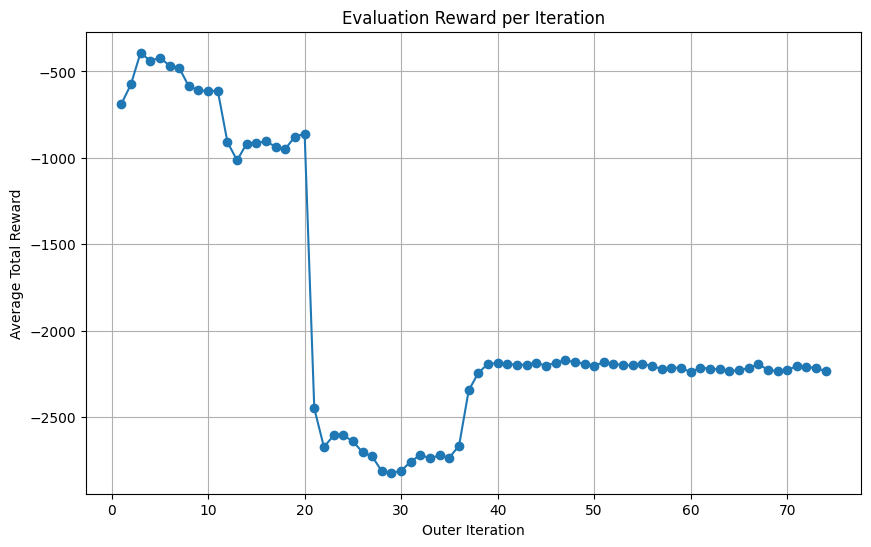

Reward plot saved to results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 1
# max_u = 10
max_u = 1
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 1000
start_steps = 100
update_after = 0
update_every = 10
plot_every = 100
plot_step = plot_every / update_every

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % plot_step == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### X_0 = 0, sigma 0.1, x_s_ratio = 5, domain [-1, 1] xavier gain None

0.9900498337491681
Start evaluating
tensor(-879.1158)
Step 0: Reward -1.303 
Step 100: Reward -1.154 
Step 200: Reward -4.610 
Start evaluating
Evaluation Average Reward: -8.5391e+02 Time: 0.67s
Start evaluating
Evaluation Average Reward: -8.2110e+02 Time: 0.99s
Start evaluating
Evaluation Average Reward: -7.6544e+02 Time: 1.29s
Start evaluating
Evaluation Average Reward: -7.4358e+02 Time: 1.59s
Start evaluating
Evaluation Average Reward: -7.0862e+02 Time: 1.88s
Step 300: Reward -27.286 
Start evaluating
Evaluation Average Reward: -7.0311e+02 Time: 2.18s
Start evaluating
Evaluation Average Reward: -6.6124e+02 Time: 2.49s
Start evaluating
Evaluation Average Reward: -7.0005e+02 Time: 2.81s
Start evaluating
Evaluation Average Reward: -7.2937e+02 Time: 3.10s
Start evaluating
Evaluation Average Reward: -7.3784e+02 Time: 3.41s
Start evaluating
Evaluation Average Reward: -6.5133e+02 Time: 3.71s
Start evaluating
Evaluation Average Reward: -5.9297e+02 Time: 4.02s
Start evaluating
Evaluation Ave

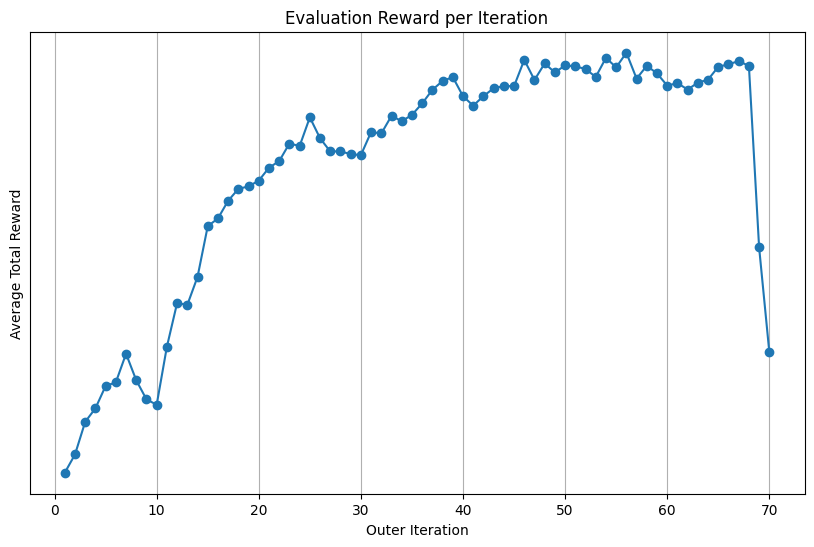

Reward plot saved to results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [46]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
# max_x = 10
max_x = 1
# max_u = 10
max_u = 1
X_min, X_max = X_domain = torch.tensor([[-1 * max_x]*d, [max_x]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-1 * max_u]*m, [max_u]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)


@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

Loaded reward history
174


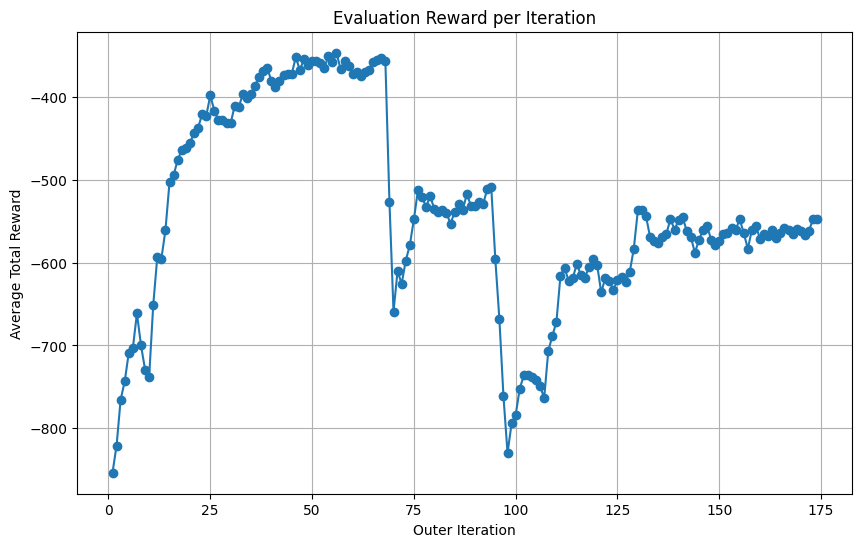

Reward plot saved to results/ms-iclr/sac/lqr_5d_sigma_0p1_u[-1,1]_x[-1,1]/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [47]:
reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.yscale('linear')
# plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### X_0 = 0, x_s_ratio = 5, affine,  y_s_ratio = 2, sigma = 0.1, eval_traj_len = 50, num_steps = 2000, rho = 0.5

In [41]:
# 표준 라이브러리
import math
import os
import pickle
import time
from typing import Callable
from os import path, makedirs

# 외부 라이브러리
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
from torch.func import jacrev, vmap
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt


# 0) 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 결과 저장을 위한 디렉토리 생성



# 데이터 로드
from os import path, makedirs


try:
    matrix = np.load(path.join("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz"))
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found.")
    print("Using random matrices for demonstration.")
    A_np = np.random.randn(5, 5)
    B_np = np.random.randn(5, 5)
    matrix = {'A': A_np, 'B': B_np}


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

print(gym.__file__)

print(A.shape)
print(B.shape)
dimension = 5

B

def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# # diffusion 함수: constant diagonal noise
# def sigma(x, u):
#     # 고정된 대각 행렬 (작은 스케일)
#     S = 0.01 * torch.eye(d, device=device)
#     return S.unsqueeze(0).expand(x.shape[0], d, d)

r_x_ratio = 1.
r_y_ratio = 2.
affine_u = True
# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u, affine_u=affine_u):
    cost_x = r_x_ratio * torch.sum(x**2, dim=1)
    if affine_u:
        affine_u = r_y_ratio * torch.ones_like(u)
        cost_u = torch.sum((u-affine_u)**2, dim=1)
    else:
        cost_u = r_y_ratio * torch.sum(u**2, dim=1)
    
    return -(cost_x + cost_u)

d, m = 5, 5
# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)

# 2) 하이퍼파라미터

d = X_domain.shape[1]
m = U_domain.shape[1]

outer_iters = 25 # 전체 정책 반복 횟수
num_steps = 2000
batch_size = 256
exponent = 0.5

lr_v = 1e-4    # 가치 네트워크 학습률
# sigma = 0.1
sigma = 0.1



# 평가용 하이퍼파라미터
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 50       # 각 궤적의 길이
eval_dt= 0.02
eval_x0_weight = 0.
rho = 0.5      # 할인율
gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

#results_dir = f"results/ms-iclr/pinn-pi/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}"
results_dir = f"results/ms-iclr/sac/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}_num_steps={num_steps}_outer{outer_iters}_rho={rho}_affine_{affine_u}"
makedirs(results_dir, exist_ok=True)


# # ─── Value Network ───────────────────────────────────────────────────────
# class ValueNet(nn.Module):
#     def __init__(self, S=dimension, hidden=100):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(S, hidden), nn.SiLU(),
#             nn.Linear(hidden, hidden), nn.SiLU(),
#             nn.Linear(hidden, 1)
#         )
#     def forward(self, x):
#         return self.net(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128,128]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            # layers.append(nn.SiLU())
            layers.append(nn.Tanh())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim, 1, hidden_dims)

    def forward(self, x):
        return self.net(x)

# 4) 보조 함수
def grad(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    return torch.autograd.grad(v_out.sum(), x, create_graph=False)[0]

def grad_and_hess_diag(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    grad_v = torch.autograd.grad(v_out.sum(), x, create_graph=True)[0]
    hess_diag = []
    for i in range(x.shape[1]):
        g_i = grad_v[:, i].sum()
        h_ii = torch.autograd.grad(g_i, x, retain_graph=True)[0][:, i]
        hess_diag.append(h_ii)
    hess_diag = torch.stack(hess_diag, dim=1)
    return grad_v, hess_diag

def laplacain(x,v_func):
    _, hess_diag = grad_and_hess_diag(x, v_func)
    return (hess_diag).sum(dim=-1) # [B]

# 5) 평가 함수
def choose_action(nabla_v, B, U_domain):
    """
    B         : (n, m)  torch.Tensor
    nabla_v   : (n,)    torch.Tensor   — ∇V(x)
    U_domain  : 하한·상한 정의
                • (u_min, u_max)  → 두 개의 스칼라(모든 축 동일 범위)
                • ((m,2) tensor) → 각 축별 [min,max]

    반환값     : (m,) torch.Tensor — 제어 입력 u, U_domain 에서 clip
    """
    single_input = False
    if nabla_v.dim() == 1:
        nabla_v = nabla_v.unsqueeze(0)
        single_input = True

    # 배치-행렬 곱 : (batch,n) @ (n,m) → (batch,m)
    u = -0.5 * torch.matmul(nabla_v, B)

    # 클리핑
    u_min, u_max = -10, 10
    # u = u_max * torch.tanh(u/u_max)
    u = torch.clamp(u, u_min, u_max)

    return u.squeeze(0) if single_input else u

# R = torch.eye(dimension, device=device)
# def choose_action(nabla_v: torch.Tensor,
#                       B: torch.Tensor,
#                       u_max) -> torch.Tensor:
#     """
#     LQR greedy action:
#         u* = argmax_{‖u‖_∞ ≤ u_max} [ -u^T R u + (B^T nabla_v)^T u ]
#            = clip( 0.5 * R^{-1} B^T nabla_v , -u_max, u_max )
#     Args
#       nabla_v: [B, d]  ∇_x v_n(x) for each state in the batch
#       B      : [d, m]  control matrix in dX/dt = A x + B u
#       R      : [m, m]  SPD control weight
#       u_max  : float or [m]-tensor, ∞-norm bound per component
#     Returns
#       u: [B, m]
#     """
#     device = nabla_v.device
#     # rhs = (B^T g) for each batch row g
#     rhs = nabla_v @ B              # [B, m] (since (B^T g) = (g^T B)^T)
#     import pdb; pdb.set_trace()

#     # solve (2 R) u = rhs^T  → u_hat = 0.5 * R^{-1} B^T g
#     R2 = 2.0 * R                   # [m, m]
#     u_hat = torch.linalg.solve(R2, rhs.T).T  # [B, m]

#     # project onto the ∞-box: componentwise clip
#     if not torch.is_tensor(u_max):
#         u_max = torch.tensor(u_max, device=device)
#     u = torch.clamp(u_hat, -u_max, u_max)
#     return u

# def dynamics(state: torch.Tensor):
#     return state

# TODO
# def choose_action_yj(value_net: nn.Module, states: torch.Tensor) -> torch.Tensor:
#     """
#     For training.
#     states: Tensor of shape [B, 2]
#     returns: Tensor of shape [B] with greedy actions
#     """
#     states = states.clone().detach().requires_grad_(True)  # [B, 2]

#     v_s = value_net(states)  # [B, 1]
#     grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]

#     B = states.shape[0]
    
#     def f_row(si, ai):
#         ai = ai.unsqueeze(0)  # shape [1]
#         si = si.unsqueeze(0)  # shape [1, state_dim]
#         fi = (dynamics(si) - si) / eval_dt  # shape: [1, 2]
#         return fi.squeeze(0)  # shape: [2]

#     a = torch.zeros(B, device=device) # [B]
#     # apply row-wise jacobian and extract df[i]/da[i]
#     a_grad = vmap(jacrev(f_row, argnums=1))(states, a)  # shape: [B, 2, 1]
#     #print(a_grad.shape)
#     a_grad = a_grad.squeeze(-1)              # shape: [B, 2]
#     #print(a_grad.shape)
#     u =  torch.sum(a_grad * grad_v, dim=1) / 4 # [B]
#     u_min, u_max = -10, 10
#     return torch.clip(u, u_min, u_max)

def evaluate_policy(sigma, num_traj, traj_len, B, value_net, dt, U_domain):
    print('Start evaluating')
    value_net.eval() # 평가 모드
    dimension = B.shape[0]
    # x = torch.zeros(num_traj, dimension, device=device)
    # x = 0.1 * torch.ones(num_traj, dimension, device=device)
    x = eval_x0_weight * torch.ones(num_traj, dimension, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device) 
    for t in range(traj_len):
        nabla_v = grad(x, value_net)
        u = choose_action(nabla_v, B,  U_domain)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        _sigma = sigma * torch.eye(d, device=device).unsqueeze(0).expand(x.shape[0], d, d)
        diffusion_term = (_sigma @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    value_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward).item(), x_norm_hist

def train_value_parallel(
    value_net: nn.Module,
    opt_v: torch.optim.Optimizer,
    choose_action: Callable,
    epochs: int = 1000,
    batch_size: int = 64,
    device: str = 'cpu',
    exponent: float = 1.0,
    sigma = 0.01,
    b=None
):
    mse_loss = nn.MSELoss()
    # value_net_copy = type(value_net)(d).to(device)
    # value_net_copy.load_state_dict(value_net.state_dict())
    
    start = time.time()

    for epoch in range(1, epochs + 1):
        # 1) 상태 샘플링
        X_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        
        high = 10
        low = -10
        states = (high - low) * torch.rand(batch_size, 5,
                                         device=device) + low
        opt_v.zero_grad()

        # 2) v(s), ∇v(s)
        states.requires_grad_(True)
        v_s = value_net(states)  # [B, 1]
        grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]
        laplacian = torch.zeros(states.shape[0], device=device)
        for i in range(states.shape[1]):
            # grad_v[:, i] 에 대한 states[:, i] 방향 2차 도함수
            second_deriv = torch.autograd.grad(grad_v[:, i].sum(), states, create_graph=True)[0][:, i]
            laplacian = laplacian + second_deriv
        # trace term: (1/2) * σ^2 * laplacian
        
        trace_term = 0.5 * sigma**2 * laplacian.unsqueeze(1)  # [B, 1]

        # 3) greedy action (벡터화)
        U_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        actions = choose_action(grad_v, B, U_domain)  # [B]
        
        
        # 4) dynamics
#         next_states = b(states.detach(), actions)  # [B, 2]
        b_tensor =  b(states.detach(), actions)   

        # 5) PDE 잔차
        
        reward = r(states.detach(), actions)
        dot_product = torch.sum(b_tensor * grad_v, dim=1, keepdim=True)  # [B, 1]
        residuals = exponent * v_s - trace_term - dot_product - reward.unsqueeze(1)  # [B, 1]

        # 6) 손실 계산 및 업데이트
        loss = mse_loss(residuals, torch.zeros_like(residuals))
        loss.backward()
        opt_v.step()

        if epoch % 500 == 0:
            elapsed = time.time() - start
            print(f"[Epoch {epoch}/{epochs}] PDE MSE Loss: {loss.item():.4e}  Runtime: {elapsed:.2f}sec")



@torch.no_grad()
def get_trajectories_sac(
    actor: nn.Module,
    b,                      # drift: b(x,u) -> [N,d]
    sigma,                  # diffusion: sigma(x,u) -> [N,d,d]
    r,                      # reward: r(x,u) -> [N]
    num_traj: int,
    traj_len: int,
    dt: float,
    x0: torch.Tensor | None = None,         # [N,d], default zeros
    clamp_X: tuple[float, float] | None = None,  # e.g., (-10., 10.) or None
    gamma: float | None = None,
    q_net: nn.Module | None = None,         # optional: track Q(s,a)
):
    """
    Returns a dict with rollouts (same shapes as your LQR version, plus optional logp/Q):
      X: [T+1, N, d], U: [T, N, m], R: [T, N], G: [N]
      x_norm: [T+1, N], u_norm: [T, N], t: [T+1], t_u: [T]
      If available: logp: [T, N], Q: [T, N]
    """
    device = next(actor.parameters()).device
    # depends on your globals d, m; if you prefer, infer from x0
    d_ = x0.shape[1] if x0 is not None else d
    m_ = m

    # init states
    if x0 is None:
        x = torch.zeros(num_traj, d_, device=device)
    else:
        assert x0.shape == (num_traj, d_)
        x = x0.to(device)

    # allocate
    X    = torch.zeros(traj_len + 1, num_traj, d_, device=device)
    U    = torch.zeros(traj_len,     num_traj, m_, device=device)
    R_t  = torch.zeros(traj_len,     num_traj, device=device)
    LOGP = torch.zeros(traj_len,     num_traj, device=device)  # optional
    Qval = torch.zeros(traj_len,     num_traj, device=device)  # optional

    X[0] = x
    sqrt_dt = math.sqrt(dt)

    # eval mode to freeze any dropout/BN
    was_training = actor.training
    actor.eval()
    if q_net is not None:
        was_training_q = q_net.training
        q_net.eval()

    for t in range(traj_len):
        # sample action from SAC policy
        u, logp = actor.sample(x)          # u: [N,m], logp: [N,1] or [N]
        if logp is None:
            logp = torch.zeros(x.size(0), 1, device=device)

        U[t]   = u
        LOGP[t] = logp.view(-1)

        # reward at current step
        R_t[t] = r(x, u)

        # optional Q tracking
        if q_net is not None:
            Qval[t] = q_net(x, u).view(-1)

        # Euler–Maruyama
        drift = b(x, u)                                    # [N,d]
        S = sigma(x, u)                                    # [N,d,d]
        dW = torch.randn(x.size(0), d_, device=device)     # [N,d]
        x = x + drift * dt + (S @ dW.unsqueeze(-1)).squeeze(-1) * sqrt_dt

        if clamp_X is not None:
            x = torch.clamp(x, clamp_X[0], clamp_X[1])

        X[t+1] = x

    # discounted return per trajectory (optional)
    if gamma is not None:
        weights = (gamma ** torch.arange(traj_len, device=device)).unsqueeze(1)  # [T,1]
        G = (R_t * weights).sum(dim=0)  # [N]
    else:
        G = R_t.sum(dim=0)

    # convenience extras + time axes
    x_norm = X.norm(dim=2)            # [T+1, N]
    u_norm = U.norm(dim=2)            # [T, N]
    t = torch.arange(traj_len + 1, device=device) * dt
    t_u = torch.arange(traj_len, device=device) * dt

    # restore modes
    if was_training:
        actor.train()
    if q_net is not None and was_training_q:
        q_net.train()

    out = {
        "X": X, "U": U, "R": R_t, "G": G,
        "x_norm": x_norm, "u_norm": u_norm,
        "t": t, "t_u": t_u
    }
    # attach optional tracks only if meaningful
    if LOGP.abs().sum() > 0:
        out["logp"] = LOGP
    if q_net is not None:
        out["Q"] = Qval
    return out


# ===================== Plotting helper (SAC-friendly) =====================
def plot_trajectories_sac(traj: dict,
                          state_idxs=None,    # e.g., [0,1,2]; None → up to 3
                          action_idxs=None,   # e.g., [0,1];  None → up to 2
                          n_samples: int = 5,
                          title_prefix: str = "SAC rollout",
                          savepath: str | None = None):
    """
    Plots:
      1) selected state components (few sample trajectories + batch mean)
      2) selected action components (few samples + batch mean)
      3) state norm (mean ± std)
      4) action norm (mean ± std) with reward mean (twin axis)
      5) optional: −log π(a|x) mean (approx entropy) and/or Q(s,a) mean (twin)
    """
    import matplotlib.pyplot as plt

    def to_np(x): return x.detach().cpu().numpy()

    X = to_np(traj["X"])        # [T+1, N, d]
    U = to_np(traj["U"])        # [T, N, m]
    R = to_np(traj["R"])        # [T, N]
    t = to_np(traj["t"])        # [T+1]
    t_u = to_np(traj["t_u"])    # [T]
    x_norm = to_np(traj["x_norm"])  # [T+1, N]
    u_norm = to_np(traj["u_norm"])  # [T, N]

    has_logp = "logp" in traj
    has_Q    = "Q" in traj
    LOGP = to_np(traj["logp"]) if has_logp else None       # [T,N]
    QVAL = to_np(traj["Q"]) if has_Q else None             # [T,N]

    T_plus_1, N, d = X.shape
    T, _, m = U.shape

    if state_idxs is None:
        state_idxs = list(range(min(d, 3)))
    if action_idxs is None:
        action_idxs = list(range(min(m, 2)))

    sample_ids = np.linspace(0, N-1, num=min(N, n_samples), dtype=int)

    n_rows = 4 + int(has_logp or has_Q)
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 3*n_rows), sharex=False)

    # 1) state components
    ax = axes[0]
    for i in state_idxs:
        ax.plot(t, X[:, :, i].mean(axis=1), label=f"x[{i}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t, X[:, sid, i], alpha=0.25)
    ax.set_title(f"{title_prefix} — state components")
    ax.set_xlabel("time")
    ax.set_ylabel("x_i")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 2) action components
    ax = axes[1]
    for j in action_idxs:
        ax.plot(t_u, U[:, :, j].mean(axis=1), label=f"u[{j}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t_u, U[:, sid, j], alpha=0.25)
    ax.set_title("action components")
    ax.set_xlabel("time")
    ax.set_ylabel("u_j")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 3) state norm
    ax = axes[2]
    mu = x_norm.mean(axis=1); sd = x_norm.std(axis=1)
    ax.plot(t, mu, label="‖x‖ mean", linewidth=2)
    ax.fill_between(t, mu - sd, mu + sd, alpha=0.2)
    ax.set_title("state norm (mean ± std)")
    ax.set_xlabel("time")
    ax.set_ylabel("‖x‖")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")

    # 4) action norm + reward (twin)
    ax = axes[3]
    mu = u_norm.mean(axis=1); sd = u_norm.std(axis=1)
    ax.plot(t_u, mu, label="‖u‖ mean", linewidth=2)
    ax.fill_between(t_u, mu - sd, mu + sd, alpha=0.2)
    ax.set_xlabel("time")
    ax.set_ylabel("‖u‖")
    ax.set_title("action norm and reward")
    ax.grid(True, alpha=0.3)
    ax2 = ax.twinx()
    r_mu = R.mean(axis=1); r_sd = R.std(axis=1)
    ax2.plot(t_u, r_mu, linestyle="--", label="reward mean")
    ax2.fill_between(t_u, r_mu - r_sd, r_mu + r_sd, alpha=0.15)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")
    ax2.set_ylabel("r_t")

    # 5) optional entropy proxy and/or Q
    if n_rows > 4:
        ax = axes[4]
        plotted = False
        if has_logp:
            neg_logp_mu = (-LOGP).mean(axis=1)
            neg_logp_sd = (-LOGP).std(axis=1)
            ax.plot(t_u, neg_logp_mu, label="−log π(a|x) mean", linewidth=2)
            ax.fill_between(t_u, neg_logp_mu - neg_logp_sd, neg_logp_mu + neg_logp_sd, alpha=0.2)
            plotted = True
        if has_Q:
            ax2 = ax.twinx()
            q_mu = QVAL.mean(axis=1); q_sd = QVAL.std(axis=1)
            ax2.plot(t_u, q_mu, linestyle="--", label="Q(s,a) mean")
            ax2.fill_between(t_u, q_mu - q_sd, q_mu + q_sd, alpha=0.15)
            # combine legends
            L1, L1n = ax.get_legend_handles_labels()
            L2, L2n = ax2.get_legend_handles_labels()
            ax2.legend(L1 + L2, L1n + L2n, loc="upper right")
        if plotted:
            ax.set_title("entropy / Q tracks")
            ax.set_xlabel("time")
            ax.set_ylabel("−log π")
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=150)
    plt.show()



value_net = ValueNet(d).to(device)
opt_v     = optim.Adam(value_net.parameters(), lr=lr_v)

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)
print(eval_reward)

# ─── Main Loop: Approximate Policy Iteration ───────────────────────────────
start = time.time()
total_reward = []
total_step = []

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)

print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
total_reward.append(eval_reward)

for it in range(outer_iters):
    opt_v.zero_grad()

    # 가치함수 업데이트
    train_value_parallel( value_net=value_net,
                            opt_v=opt_v,
                            choose_action = choose_action,
                            epochs=num_steps, batch_size=batch_size, device=device,
                            exponent=exponent, sigma = sigma,  b=b)
    elapsed = time.time() - start
    print(f"[Iter {it+1}/{outer_iters}] Runtime: {elapsed:.2f}sec")
    print("Evaluation start")

    opt_v.zero_grad()
    eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                             eval_traj_len, B, value_net,
                                             eval_dt, U_domain)

    print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
    total_reward.append(eval_reward)


with open(os.path.join(results_dir, 'Value.pkl'), 'wb') as f:
    pickle.dump(total_reward, f)




# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward) + 1), total_reward, marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

# random x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=torch.randn(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_random_x0.png"
)



# eval x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=eval_x0_weight * torch.ones(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_eval_x0.png"
)


Using device: cuda
/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/__init__.py
torch.Size([5, 5])
torch.Size([5, 5])
0.9900498337491681
Start evaluating
-793.757080078125
Start evaluating
Estimated Value: -793.9815673828125 Runtime: 1.0304551124572754
[Epoch 500/2000] PDE MSE Loss: 3.4405e+04  Runtime: 140.49sec
[Epoch 1000/2000] PDE MSE Loss: 2.8023e+04  Runtime: 291.91sec
[Epoch 1500/2000] PDE MSE Loss: 2.1921e+04  Runtime: 377.98sec
[Epoch 2000/2000] PDE MSE Loss: 1.8359e+04  Runtime: 457.87sec
[Iter 1/25] Runtime: 458.91sec
Evaluation start
Start evaluating
Estimated Value: -792.3870849609375 Runtime: 459.4151244163513
[Epoch 500/2000] PDE MSE Loss: 1.7553e+04  Runtime: 78.70sec
[Epoch 1000/2000] PDE MSE Loss: 1.6486e+04  Runtime: 155.62sec
[Epoch 1500/2000] PDE MSE Loss: 1.4613e+04  Runtime: 234.43sec
[Epoch 2000/2000] PDE MSE Loss: 1.2633e+04  Runtime: 310.35sec
[Iter 2/25] Runtime: 769.76sec
Evaluation start
Start evaluating
Estim

KeyboardInterrupt: 

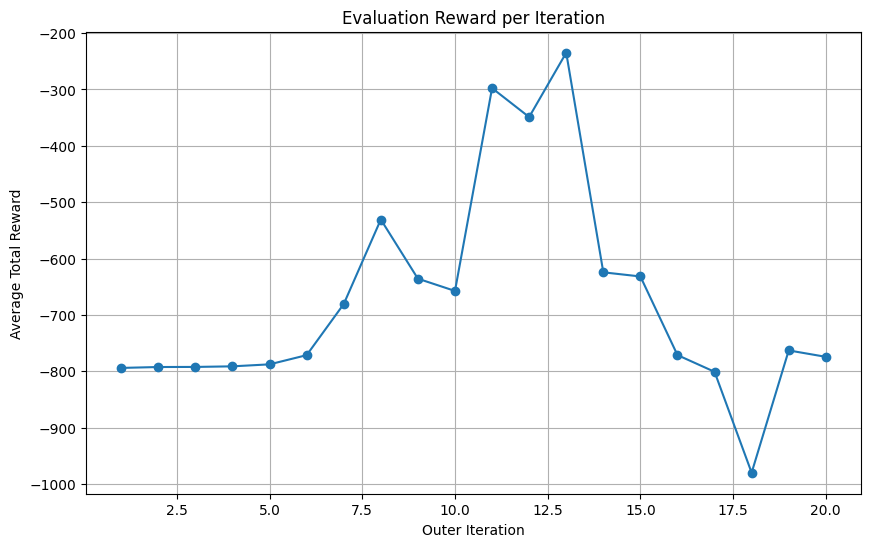

Reward plot saved to results/ms-iclr/sac/lqr_5d_x0=0.0_sigma=0.1_eval_traj_len=30_num_steps=2000_outer25_rho=0.5_affine_True/reward_plot.png


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

<Figure size 640x480 with 0 Axes>

In [42]:
with open(os.path.join(results_dir, 'Value.pkl'), 'wb') as f:
    pickle.dump(total_reward, f)




# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward) + 1), total_reward, marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

# random x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=torch.randn(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_random_x0.png"
)



# eval x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=eval_x0_weight * torch.ones(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_eval_x0.png"
)

### X_0 = 0, sigma = 0.01, eval_traj_len = 50, rho = 0.99

Using device: cuda
/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/__init__.py
torch.Size([5, 5])
torch.Size([5, 5])
0.9803947326466971
Start evaluating
-0.05315256118774414
Start evaluating
Estimated Value: -0.050010330975055695 Runtime: 0.29207587242126465
[Epoch 500/2000] PDE MSE Loss: 7.2892e+05  Runtime: 45.64sec
[Epoch 1000/2000] PDE MSE Loss: 6.7635e+05  Runtime: 92.18sec
[Epoch 1500/2000] PDE MSE Loss: 7.1834e+05  Runtime: 138.83sec
[Epoch 2000/2000] PDE MSE Loss: 7.3094e+05  Runtime: 185.37sec
[Iter 1/25] Runtime: 185.66sec
Evaluation start
Start evaluating
Estimated Value: -0.048441484570503235 Runtime: 185.98708772659302
[Epoch 500/2000] PDE MSE Loss: 6.6657e+05  Runtime: 57.54sec
[Epoch 1000/2000] PDE MSE Loss: 6.3112e+05  Runtime: 112.53sec
[Epoch 1500/2000] PDE MSE Loss: 6.5797e+05  Runtime: 170.80sec
[Epoch 2000/2000] PDE MSE Loss: 6.1571e+05  Runtime: 222.83sec
[Iter 2/25] Runtime: 408.82sec
Evaluation start
Start evaluat

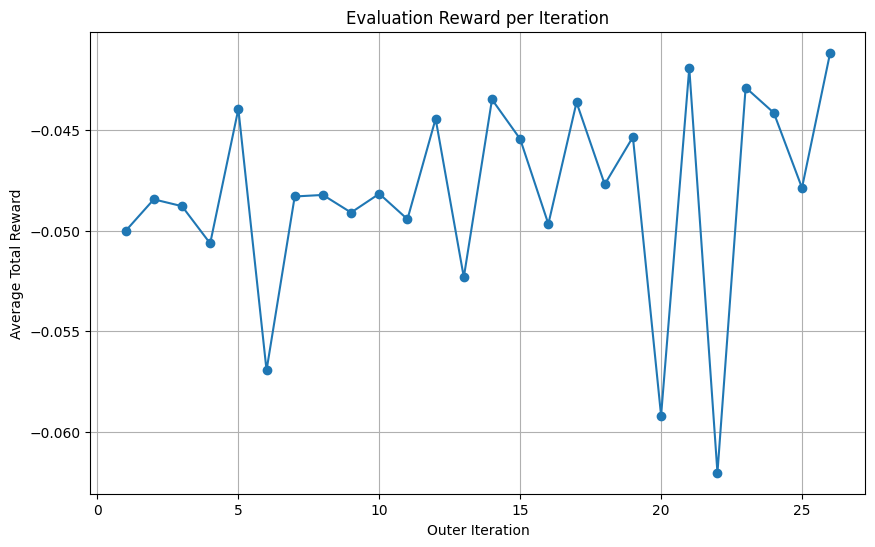

Reward plot saved to results/ms-iclr/sac/lqr_5d_x0=0.0_sigma=0.01_eval_traj_len=30_num_steps=2000_outer25_rho=0.99/reward_plot.png


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

<Figure size 640x480 with 0 Axes>

In [40]:
# 표준 라이브러리
import math
import os
import pickle
import time
from typing import Callable
from os import path, makedirs

# 외부 라이브러리
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
from torch.func import jacrev, vmap
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt


# 0) 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 결과 저장을 위한 디렉토리 생성



# 데이터 로드
from os import path, makedirs


try:
    matrix = np.load(path.join("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz"))
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found.")
    print("Using random matrices for demonstration.")
    A_np = np.random.randn(5, 5)
    B_np = np.random.randn(5, 5)
    matrix = {'A': A_np, 'B': B_np}


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

print(gym.__file__)

print(A.shape)
print(B.shape)
dimension = 5

B

def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# # diffusion 함수: constant diagonal noise
# def sigma(x, u):
#     # 고정된 대각 행렬 (작은 스케일)
#     S = 0.01 * torch.eye(d, device=device)
#     return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    # affine_u = torch.ones_like(u)
    # cost_u = torch.sum((u-affine_u)**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    
    return -(cost_x + cost_u)


d, m = 5, 5
# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)

# 2) 하이퍼파라미터

d = X_domain.shape[1]
m = U_domain.shape[1]

outer_iters = 25 # 전체 정책 반복 횟수
num_steps = 2000
batch_size = 256
exponent = 0.5

lr_v = 1e-4    # 가치 네트워크 학습률
# sigma = 0.1
sigma = 0.01



# 평가용 하이퍼파라미터
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 50       # 각 궤적의 길이
eval_dt= 0.02
eval_x0_weight = 0.
rho = 0.99      # 할인율
gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

#results_dir = f"results/ms-iclr/pinn-pi/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}"
results_dir = f"results/ms-iclr/sac/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}_num_steps={num_steps}_outer{outer_iters}_rho={rho}"
makedirs(results_dir, exist_ok=True)


# # ─── Value Network ───────────────────────────────────────────────────────
# class ValueNet(nn.Module):
#     def __init__(self, S=dimension, hidden=100):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(S, hidden), nn.SiLU(),
#             nn.Linear(hidden, hidden), nn.SiLU(),
#             nn.Linear(hidden, 1)
#         )
#     def forward(self, x):
#         return self.net(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128,128]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            # layers.append(nn.SiLU())
            layers.append(nn.Tanh())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim, 1, hidden_dims)

    def forward(self, x):
        return self.net(x)

# 4) 보조 함수
def grad(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    return torch.autograd.grad(v_out.sum(), x, create_graph=False)[0]

def grad_and_hess_diag(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    grad_v = torch.autograd.grad(v_out.sum(), x, create_graph=True)[0]
    hess_diag = []
    for i in range(x.shape[1]):
        g_i = grad_v[:, i].sum()
        h_ii = torch.autograd.grad(g_i, x, retain_graph=True)[0][:, i]
        hess_diag.append(h_ii)
    hess_diag = torch.stack(hess_diag, dim=1)
    return grad_v, hess_diag

def laplacain(x,v_func):
    _, hess_diag = grad_and_hess_diag(x, v_func)
    return (hess_diag).sum(dim=-1) # [B]

# 5) 평가 함수
def choose_action(nabla_v, B, U_domain):
    """
    B         : (n, m)  torch.Tensor
    nabla_v   : (n,)    torch.Tensor   — ∇V(x)
    U_domain  : 하한·상한 정의
                • (u_min, u_max)  → 두 개의 스칼라(모든 축 동일 범위)
                • ((m,2) tensor) → 각 축별 [min,max]

    반환값     : (m,) torch.Tensor — 제어 입력 u, U_domain 에서 clip
    """
    single_input = False
    if nabla_v.dim() == 1:
        nabla_v = nabla_v.unsqueeze(0)
        single_input = True

    # 배치-행렬 곱 : (batch,n) @ (n,m) → (batch,m)
    u = -0.5 * torch.matmul(nabla_v, B)

    # 클리핑
    u_min, u_max = -10, 10
    # u = u_max * torch.tanh(u/u_max)
    u = torch.clamp(u, u_min, u_max)

    return u.squeeze(0) if single_input else u

# R = torch.eye(dimension, device=device)
# def choose_action(nabla_v: torch.Tensor,
#                       B: torch.Tensor,
#                       u_max) -> torch.Tensor:
#     """
#     LQR greedy action:
#         u* = argmax_{‖u‖_∞ ≤ u_max} [ -u^T R u + (B^T nabla_v)^T u ]
#            = clip( 0.5 * R^{-1} B^T nabla_v , -u_max, u_max )
#     Args
#       nabla_v: [B, d]  ∇_x v_n(x) for each state in the batch
#       B      : [d, m]  control matrix in dX/dt = A x + B u
#       R      : [m, m]  SPD control weight
#       u_max  : float or [m]-tensor, ∞-norm bound per component
#     Returns
#       u: [B, m]
#     """
#     device = nabla_v.device
#     # rhs = (B^T g) for each batch row g
#     rhs = nabla_v @ B              # [B, m] (since (B^T g) = (g^T B)^T)
#     import pdb; pdb.set_trace()

#     # solve (2 R) u = rhs^T  → u_hat = 0.5 * R^{-1} B^T g
#     R2 = 2.0 * R                   # [m, m]
#     u_hat = torch.linalg.solve(R2, rhs.T).T  # [B, m]

#     # project onto the ∞-box: componentwise clip
#     if not torch.is_tensor(u_max):
#         u_max = torch.tensor(u_max, device=device)
#     u = torch.clamp(u_hat, -u_max, u_max)
#     return u

# def dynamics(state: torch.Tensor):
#     return state

# TODO
# def choose_action_yj(value_net: nn.Module, states: torch.Tensor) -> torch.Tensor:
#     """
#     For training.
#     states: Tensor of shape [B, 2]
#     returns: Tensor of shape [B] with greedy actions
#     """
#     states = states.clone().detach().requires_grad_(True)  # [B, 2]

#     v_s = value_net(states)  # [B, 1]
#     grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]

#     B = states.shape[0]
    
#     def f_row(si, ai):
#         ai = ai.unsqueeze(0)  # shape [1]
#         si = si.unsqueeze(0)  # shape [1, state_dim]
#         fi = (dynamics(si) - si) / eval_dt  # shape: [1, 2]
#         return fi.squeeze(0)  # shape: [2]

#     a = torch.zeros(B, device=device) # [B]
#     # apply row-wise jacobian and extract df[i]/da[i]
#     a_grad = vmap(jacrev(f_row, argnums=1))(states, a)  # shape: [B, 2, 1]
#     #print(a_grad.shape)
#     a_grad = a_grad.squeeze(-1)              # shape: [B, 2]
#     #print(a_grad.shape)
#     u =  torch.sum(a_grad * grad_v, dim=1) / 4 # [B]
#     u_min, u_max = -10, 10
#     return torch.clip(u, u_min, u_max)

def evaluate_policy(sigma, num_traj, traj_len, B, value_net, dt, U_domain):
    print('Start evaluating')
    value_net.eval() # 평가 모드
    dimension = B.shape[0]
    # x = torch.zeros(num_traj, dimension, device=device)
    # x = 0.1 * torch.ones(num_traj, dimension, device=device)
    x = eval_x0_weight * torch.ones(num_traj, dimension, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device) 
    for t in range(traj_len):
        nabla_v = grad(x, value_net)
        u = choose_action(nabla_v, B,  U_domain)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        _sigma = sigma * torch.eye(d, device=device).unsqueeze(0).expand(x.shape[0], d, d)
        diffusion_term = (_sigma @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    value_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward).item(), x_norm_hist

def train_value_parallel(
    value_net: nn.Module,
    opt_v: torch.optim.Optimizer,
    choose_action: Callable,
    epochs: int = 1000,
    batch_size: int = 64,
    device: str = 'cpu',
    exponent: float = 1.0,
    sigma = 0.01,
    b=None
):
    mse_loss = nn.MSELoss()
    # value_net_copy = type(value_net)(d).to(device)
    # value_net_copy.load_state_dict(value_net.state_dict())
    
    start = time.time()

    for epoch in range(1, epochs + 1):
        # 1) 상태 샘플링
        X_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        
        high = 10
        low = -10
        states = (high - low) * torch.rand(batch_size, 5,
                                         device=device) + low
        opt_v.zero_grad()

        # 2) v(s), ∇v(s)
        states.requires_grad_(True)
        v_s = value_net(states)  # [B, 1]
        grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]
        laplacian = torch.zeros(states.shape[0], device=device)
        for i in range(states.shape[1]):
            # grad_v[:, i] 에 대한 states[:, i] 방향 2차 도함수
            second_deriv = torch.autograd.grad(grad_v[:, i].sum(), states, create_graph=True)[0][:, i]
            laplacian = laplacian + second_deriv
        # trace term: (1/2) * σ^2 * laplacian
        
        trace_term = 0.5 * sigma**2 * laplacian.unsqueeze(1)  # [B, 1]

        # 3) greedy action (벡터화)
        U_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        actions = choose_action(grad_v, B, U_domain)  # [B]
        
        
        # 4) dynamics
#         next_states = b(states.detach(), actions)  # [B, 2]
        b_tensor =  b(states.detach(), actions)   

        # 5) PDE 잔차
        
        reward = r(states.detach(), actions)
        dot_product = torch.sum(b_tensor * grad_v, dim=1, keepdim=True)  # [B, 1]
        residuals = exponent * v_s - trace_term - dot_product - reward.unsqueeze(1)  # [B, 1]

        # 6) 손실 계산 및 업데이트
        loss = mse_loss(residuals, torch.zeros_like(residuals))
        loss.backward()
        opt_v.step()

        if epoch % 500 == 0:
            elapsed = time.time() - start
            print(f"[Epoch {epoch}/{epochs}] PDE MSE Loss: {loss.item():.4e}  Runtime: {elapsed:.2f}sec")



@torch.no_grad()
def get_trajectories_sac(
    actor: nn.Module,
    b,                      # drift: b(x,u) -> [N,d]
    sigma,                  # diffusion: sigma(x,u) -> [N,d,d]
    r,                      # reward: r(x,u) -> [N]
    num_traj: int,
    traj_len: int,
    dt: float,
    x0: torch.Tensor | None = None,         # [N,d], default zeros
    clamp_X: tuple[float, float] | None = None,  # e.g., (-10., 10.) or None
    gamma: float | None = None,
    q_net: nn.Module | None = None,         # optional: track Q(s,a)
):
    """
    Returns a dict with rollouts (same shapes as your LQR version, plus optional logp/Q):
      X: [T+1, N, d], U: [T, N, m], R: [T, N], G: [N]
      x_norm: [T+1, N], u_norm: [T, N], t: [T+1], t_u: [T]
      If available: logp: [T, N], Q: [T, N]
    """
    device = next(actor.parameters()).device
    # depends on your globals d, m; if you prefer, infer from x0
    d_ = x0.shape[1] if x0 is not None else d
    m_ = m

    # init states
    if x0 is None:
        x = torch.zeros(num_traj, d_, device=device)
    else:
        assert x0.shape == (num_traj, d_)
        x = x0.to(device)

    # allocate
    X    = torch.zeros(traj_len + 1, num_traj, d_, device=device)
    U    = torch.zeros(traj_len,     num_traj, m_, device=device)
    R_t  = torch.zeros(traj_len,     num_traj, device=device)
    LOGP = torch.zeros(traj_len,     num_traj, device=device)  # optional
    Qval = torch.zeros(traj_len,     num_traj, device=device)  # optional

    X[0] = x
    sqrt_dt = math.sqrt(dt)

    # eval mode to freeze any dropout/BN
    was_training = actor.training
    actor.eval()
    if q_net is not None:
        was_training_q = q_net.training
        q_net.eval()

    for t in range(traj_len):
        # sample action from SAC policy
        u, logp = actor.sample(x)          # u: [N,m], logp: [N,1] or [N]
        if logp is None:
            logp = torch.zeros(x.size(0), 1, device=device)

        U[t]   = u
        LOGP[t] = logp.view(-1)

        # reward at current step
        R_t[t] = r(x, u)

        # optional Q tracking
        if q_net is not None:
            Qval[t] = q_net(x, u).view(-1)

        # Euler–Maruyama
        drift = b(x, u)                                    # [N,d]
        S = sigma(x, u)                                    # [N,d,d]
        dW = torch.randn(x.size(0), d_, device=device)     # [N,d]
        x = x + drift * dt + (S @ dW.unsqueeze(-1)).squeeze(-1) * sqrt_dt

        if clamp_X is not None:
            x = torch.clamp(x, clamp_X[0], clamp_X[1])

        X[t+1] = x

    # discounted return per trajectory (optional)
    if gamma is not None:
        weights = (gamma ** torch.arange(traj_len, device=device)).unsqueeze(1)  # [T,1]
        G = (R_t * weights).sum(dim=0)  # [N]
    else:
        G = R_t.sum(dim=0)

    # convenience extras + time axes
    x_norm = X.norm(dim=2)            # [T+1, N]
    u_norm = U.norm(dim=2)            # [T, N]
    t = torch.arange(traj_len + 1, device=device) * dt
    t_u = torch.arange(traj_len, device=device) * dt

    # restore modes
    if was_training:
        actor.train()
    if q_net is not None and was_training_q:
        q_net.train()

    out = {
        "X": X, "U": U, "R": R_t, "G": G,
        "x_norm": x_norm, "u_norm": u_norm,
        "t": t, "t_u": t_u
    }
    # attach optional tracks only if meaningful
    if LOGP.abs().sum() > 0:
        out["logp"] = LOGP
    if q_net is not None:
        out["Q"] = Qval
    return out


# ===================== Plotting helper (SAC-friendly) =====================
def plot_trajectories_sac(traj: dict,
                          state_idxs=None,    # e.g., [0,1,2]; None → up to 3
                          action_idxs=None,   # e.g., [0,1];  None → up to 2
                          n_samples: int = 5,
                          title_prefix: str = "SAC rollout",
                          savepath: str | None = None):
    """
    Plots:
      1) selected state components (few sample trajectories + batch mean)
      2) selected action components (few samples + batch mean)
      3) state norm (mean ± std)
      4) action norm (mean ± std) with reward mean (twin axis)
      5) optional: −log π(a|x) mean (approx entropy) and/or Q(s,a) mean (twin)
    """
    import matplotlib.pyplot as plt

    def to_np(x): return x.detach().cpu().numpy()

    X = to_np(traj["X"])        # [T+1, N, d]
    U = to_np(traj["U"])        # [T, N, m]
    R = to_np(traj["R"])        # [T, N]
    t = to_np(traj["t"])        # [T+1]
    t_u = to_np(traj["t_u"])    # [T]
    x_norm = to_np(traj["x_norm"])  # [T+1, N]
    u_norm = to_np(traj["u_norm"])  # [T, N]

    has_logp = "logp" in traj
    has_Q    = "Q" in traj
    LOGP = to_np(traj["logp"]) if has_logp else None       # [T,N]
    QVAL = to_np(traj["Q"]) if has_Q else None             # [T,N]

    T_plus_1, N, d = X.shape
    T, _, m = U.shape

    if state_idxs is None:
        state_idxs = list(range(min(d, 3)))
    if action_idxs is None:
        action_idxs = list(range(min(m, 2)))

    sample_ids = np.linspace(0, N-1, num=min(N, n_samples), dtype=int)

    n_rows = 4 + int(has_logp or has_Q)
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 3*n_rows), sharex=False)

    # 1) state components
    ax = axes[0]
    for i in state_idxs:
        ax.plot(t, X[:, :, i].mean(axis=1), label=f"x[{i}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t, X[:, sid, i], alpha=0.25)
    ax.set_title(f"{title_prefix} — state components")
    ax.set_xlabel("time")
    ax.set_ylabel("x_i")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 2) action components
    ax = axes[1]
    for j in action_idxs:
        ax.plot(t_u, U[:, :, j].mean(axis=1), label=f"u[{j}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t_u, U[:, sid, j], alpha=0.25)
    ax.set_title("action components")
    ax.set_xlabel("time")
    ax.set_ylabel("u_j")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 3) state norm
    ax = axes[2]
    mu = x_norm.mean(axis=1); sd = x_norm.std(axis=1)
    ax.plot(t, mu, label="‖x‖ mean", linewidth=2)
    ax.fill_between(t, mu - sd, mu + sd, alpha=0.2)
    ax.set_title("state norm (mean ± std)")
    ax.set_xlabel("time")
    ax.set_ylabel("‖x‖")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")

    # 4) action norm + reward (twin)
    ax = axes[3]
    mu = u_norm.mean(axis=1); sd = u_norm.std(axis=1)
    ax.plot(t_u, mu, label="‖u‖ mean", linewidth=2)
    ax.fill_between(t_u, mu - sd, mu + sd, alpha=0.2)
    ax.set_xlabel("time")
    ax.set_ylabel("‖u‖")
    ax.set_title("action norm and reward")
    ax.grid(True, alpha=0.3)
    ax2 = ax.twinx()
    r_mu = R.mean(axis=1); r_sd = R.std(axis=1)
    ax2.plot(t_u, r_mu, linestyle="--", label="reward mean")
    ax2.fill_between(t_u, r_mu - r_sd, r_mu + r_sd, alpha=0.15)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")
    ax2.set_ylabel("r_t")

    # 5) optional entropy proxy and/or Q
    if n_rows > 4:
        ax = axes[4]
        plotted = False
        if has_logp:
            neg_logp_mu = (-LOGP).mean(axis=1)
            neg_logp_sd = (-LOGP).std(axis=1)
            ax.plot(t_u, neg_logp_mu, label="−log π(a|x) mean", linewidth=2)
            ax.fill_between(t_u, neg_logp_mu - neg_logp_sd, neg_logp_mu + neg_logp_sd, alpha=0.2)
            plotted = True
        if has_Q:
            ax2 = ax.twinx()
            q_mu = QVAL.mean(axis=1); q_sd = QVAL.std(axis=1)
            ax2.plot(t_u, q_mu, linestyle="--", label="Q(s,a) mean")
            ax2.fill_between(t_u, q_mu - q_sd, q_mu + q_sd, alpha=0.15)
            # combine legends
            L1, L1n = ax.get_legend_handles_labels()
            L2, L2n = ax2.get_legend_handles_labels()
            ax2.legend(L1 + L2, L1n + L2n, loc="upper right")
        if plotted:
            ax.set_title("entropy / Q tracks")
            ax.set_xlabel("time")
            ax.set_ylabel("−log π")
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=150)
    plt.show()



value_net = ValueNet(d).to(device)
opt_v     = optim.Adam(value_net.parameters(), lr=lr_v)

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)
print(eval_reward)

# ─── Main Loop: Approximate Policy Iteration ───────────────────────────────
start = time.time()
total_reward = []
total_step = []

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)

print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
total_reward.append(eval_reward)

for it in range(outer_iters):
    opt_v.zero_grad()

    # 가치함수 업데이트
    train_value_parallel( value_net=value_net,
                            opt_v=opt_v,
                            choose_action = choose_action,
                            epochs=num_steps, batch_size=batch_size, device=device,
                            exponent=exponent, sigma = sigma,  b=b)
    elapsed = time.time() - start
    print(f"[Iter {it+1}/{outer_iters}] Runtime: {elapsed:.2f}sec")
    print("Evaluation start")

    opt_v.zero_grad()
    eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                             eval_traj_len, B, value_net,
                                             eval_dt, U_domain)

    print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
    total_reward.append(eval_reward)


with open(os.path.join(results_dir, 'Value.pkl'), 'wb') as f:
    pickle.dump(total_reward, f)




# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward) + 1), total_reward, marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

# random x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=torch.randn(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_random_x0.png"
)



# eval x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=eval_x0_weight * torch.ones(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_eval_x0.png"
)


### X_0 = 5, sigma = 0.01, eval_traj_len = 50, num_steps = 10, rho = 0.5

In [36]:
# 표준 라이브러리
import math
import os
import pickle
import time
from typing import Callable
from os import path, makedirs

# 외부 라이브러리
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
from torch.func import jacrev, vmap
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt


# 0) 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 결과 저장을 위한 디렉토리 생성



# 데이터 로드
from os import path, makedirs


try:
    matrix = np.load(path.join("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz"))
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found.")
    print("Using random matrices for demonstration.")
    A_np = np.random.randn(5, 5)
    B_np = np.random.randn(5, 5)
    matrix = {'A': A_np, 'B': B_np}


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

print(gym.__file__)

print(A.shape)
print(B.shape)
dimension = 5

B

def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# # diffusion 함수: constant diagonal noise
# def sigma(x, u):
#     # 고정된 대각 행렬 (작은 스케일)
#     S = 0.01 * torch.eye(d, device=device)
#     return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    # affine_u = torch.ones_like(u)
    # cost_u = torch.sum((u-affine_u)**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    
    return -(cost_x + cost_u)


d, m = 5, 5
# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)

# 2) 하이퍼파라미터

d = X_domain.shape[1]
m = U_domain.shape[1]

outer_iters = 15 # 전체 정책 반복 횟수
num_steps = 3000
batch_size = 256
exponent = 0.5

lr_v = 1e-4    # 가치 네트워크 학습률
# sigma = 0.1
sigma = 0.01



# 평가용 하이퍼파라미터
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 50       # 각 궤적의 길이
eval_dt= 0.02
eval_x0_weight = 5.
rho = 0.5      # 할인율
gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

#results_dir = f"results/ms-iclr/pinn-pi/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}"
results_dir = f"results/ms-iclr/sac/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}_num_steps={num_steps}_outer{outer_iters}_rho={rho}"
makedirs(results_dir, exist_ok=True)


# # ─── Value Network ───────────────────────────────────────────────────────
# class ValueNet(nn.Module):
#     def __init__(self, S=dimension, hidden=100):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(S, hidden), nn.SiLU(),
#             nn.Linear(hidden, hidden), nn.SiLU(),
#             nn.Linear(hidden, 1)
#         )
#     def forward(self, x):
#         return self.net(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128,128]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            # layers.append(nn.SiLU())
            layers.append(nn.Tanh())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim, 1, hidden_dims)

    def forward(self, x):
        return self.net(x)

# 4) 보조 함수
def grad(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    return torch.autograd.grad(v_out.sum(), x, create_graph=False)[0]

def grad_and_hess_diag(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    grad_v = torch.autograd.grad(v_out.sum(), x, create_graph=True)[0]
    hess_diag = []
    for i in range(x.shape[1]):
        g_i = grad_v[:, i].sum()
        h_ii = torch.autograd.grad(g_i, x, retain_graph=True)[0][:, i]
        hess_diag.append(h_ii)
    hess_diag = torch.stack(hess_diag, dim=1)
    return grad_v, hess_diag

def laplacain(x,v_func):
    _, hess_diag = grad_and_hess_diag(x, v_func)
    return (hess_diag).sum(dim=-1) # [B]

# 5) 평가 함수
def choose_action(nabla_v, B, U_domain):
    """
    B         : (n, m)  torch.Tensor
    nabla_v   : (n,)    torch.Tensor   — ∇V(x)
    U_domain  : 하한·상한 정의
                • (u_min, u_max)  → 두 개의 스칼라(모든 축 동일 범위)
                • ((m,2) tensor) → 각 축별 [min,max]

    반환값     : (m,) torch.Tensor — 제어 입력 u, U_domain 에서 clip
    """
    single_input = False
    if nabla_v.dim() == 1:
        nabla_v = nabla_v.unsqueeze(0)
        single_input = True

    # 배치-행렬 곱 : (batch,n) @ (n,m) → (batch,m)
    u = -0.5 * torch.matmul(nabla_v, B)

    # 클리핑
    u_min, u_max = -10, 10
    # u = u_max * torch.tanh(u/u_max)
    u = torch.clamp(u, u_min, u_max)

    return u.squeeze(0) if single_input else u

# R = torch.eye(dimension, device=device)
# def choose_action(nabla_v: torch.Tensor,
#                       B: torch.Tensor,
#                       u_max) -> torch.Tensor:
#     """
#     LQR greedy action:
#         u* = argmax_{‖u‖_∞ ≤ u_max} [ -u^T R u + (B^T nabla_v)^T u ]
#            = clip( 0.5 * R^{-1} B^T nabla_v , -u_max, u_max )
#     Args
#       nabla_v: [B, d]  ∇_x v_n(x) for each state in the batch
#       B      : [d, m]  control matrix in dX/dt = A x + B u
#       R      : [m, m]  SPD control weight
#       u_max  : float or [m]-tensor, ∞-norm bound per component
#     Returns
#       u: [B, m]
#     """
#     device = nabla_v.device
#     # rhs = (B^T g) for each batch row g
#     rhs = nabla_v @ B              # [B, m] (since (B^T g) = (g^T B)^T)
#     import pdb; pdb.set_trace()

#     # solve (2 R) u = rhs^T  → u_hat = 0.5 * R^{-1} B^T g
#     R2 = 2.0 * R                   # [m, m]
#     u_hat = torch.linalg.solve(R2, rhs.T).T  # [B, m]

#     # project onto the ∞-box: componentwise clip
#     if not torch.is_tensor(u_max):
#         u_max = torch.tensor(u_max, device=device)
#     u = torch.clamp(u_hat, -u_max, u_max)
#     return u

# def dynamics(state: torch.Tensor):
#     return state

# TODO
# def choose_action_yj(value_net: nn.Module, states: torch.Tensor) -> torch.Tensor:
#     """
#     For training.
#     states: Tensor of shape [B, 2]
#     returns: Tensor of shape [B] with greedy actions
#     """
#     states = states.clone().detach().requires_grad_(True)  # [B, 2]

#     v_s = value_net(states)  # [B, 1]
#     grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]

#     B = states.shape[0]
    
#     def f_row(si, ai):
#         ai = ai.unsqueeze(0)  # shape [1]
#         si = si.unsqueeze(0)  # shape [1, state_dim]
#         fi = (dynamics(si) - si) / eval_dt  # shape: [1, 2]
#         return fi.squeeze(0)  # shape: [2]

#     a = torch.zeros(B, device=device) # [B]
#     # apply row-wise jacobian and extract df[i]/da[i]
#     a_grad = vmap(jacrev(f_row, argnums=1))(states, a)  # shape: [B, 2, 1]
#     #print(a_grad.shape)
#     a_grad = a_grad.squeeze(-1)              # shape: [B, 2]
#     #print(a_grad.shape)
#     u =  torch.sum(a_grad * grad_v, dim=1) / 4 # [B]
#     u_min, u_max = -10, 10
#     return torch.clip(u, u_min, u_max)

def evaluate_policy(sigma, num_traj, traj_len, B, value_net, dt, U_domain):
    print('Start evaluating')
    value_net.eval() # 평가 모드
    dimension = B.shape[0]
    # x = torch.zeros(num_traj, dimension, device=device)
    # x = 0.1 * torch.ones(num_traj, dimension, device=device)
    x = eval_x0_weight * torch.ones(num_traj, dimension, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device) 
    for t in range(traj_len):
        nabla_v = grad(x, value_net)
        u = choose_action(nabla_v, B,  U_domain)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        _sigma = sigma * torch.eye(d, device=device).unsqueeze(0).expand(x.shape[0], d, d)
        diffusion_term = (_sigma @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    value_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward).item(), x_norm_hist

def train_value_parallel(
    value_net: nn.Module,
    opt_v: torch.optim.Optimizer,
    choose_action: Callable,
    epochs: int = 1000,
    batch_size: int = 64,
    device: str = 'cpu',
    exponent: float = 1.0,
    sigma = 0.01,
    b=None
):
    mse_loss = nn.MSELoss()
    # value_net_copy = type(value_net)(d).to(device)
    # value_net_copy.load_state_dict(value_net.state_dict())
    
    start = time.time()

    for epoch in range(1, epochs + 1):
        # 1) 상태 샘플링
        X_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        
        high = 10
        low = -10
        states = (high - low) * torch.rand(batch_size, 5,
                                         device=device) + low
        opt_v.zero_grad()

        # 2) v(s), ∇v(s)
        states.requires_grad_(True)
        v_s = value_net(states)  # [B, 1]
        grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]
        laplacian = torch.zeros(states.shape[0], device=device)
        for i in range(states.shape[1]):
            # grad_v[:, i] 에 대한 states[:, i] 방향 2차 도함수
            second_deriv = torch.autograd.grad(grad_v[:, i].sum(), states, create_graph=True)[0][:, i]
            laplacian = laplacian + second_deriv
        # trace term: (1/2) * σ^2 * laplacian
        
        trace_term = 0.5 * sigma**2 * laplacian.unsqueeze(1)  # [B, 1]

        # 3) greedy action (벡터화)
        U_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        actions = choose_action(grad_v, B, U_domain)  # [B]
        
        
        # 4) dynamics
#         next_states = b(states.detach(), actions)  # [B, 2]
        b_tensor =  b(states.detach(), actions)   

        # 5) PDE 잔차
        
        reward = r(states.detach(), actions)
        dot_product = torch.sum(b_tensor * grad_v, dim=1, keepdim=True)  # [B, 1]
        residuals = exponent * v_s - trace_term - dot_product - reward.unsqueeze(1)  # [B, 1]

        # 6) 손실 계산 및 업데이트
        loss = mse_loss(residuals, torch.zeros_like(residuals))
        loss.backward()
        opt_v.step()

        if epoch % 500 == 0:
            elapsed = time.time() - start
            print(f"[Epoch {epoch}/{epochs}] PDE MSE Loss: {loss.item():.4e}  Runtime: {elapsed:.2f}sec")



@torch.no_grad()
def get_trajectories_sac(
    actor: nn.Module,
    b,                      # drift: b(x,u) -> [N,d]
    sigma,                  # diffusion: sigma(x,u) -> [N,d,d]
    r,                      # reward: r(x,u) -> [N]
    num_traj: int,
    traj_len: int,
    dt: float,
    x0: torch.Tensor | None = None,         # [N,d], default zeros
    clamp_X: tuple[float, float] | None = None,  # e.g., (-10., 10.) or None
    gamma: float | None = None,
    q_net: nn.Module | None = None,         # optional: track Q(s,a)
):
    """
    Returns a dict with rollouts (same shapes as your LQR version, plus optional logp/Q):
      X: [T+1, N, d], U: [T, N, m], R: [T, N], G: [N]
      x_norm: [T+1, N], u_norm: [T, N], t: [T+1], t_u: [T]
      If available: logp: [T, N], Q: [T, N]
    """
    device = next(actor.parameters()).device
    # depends on your globals d, m; if you prefer, infer from x0
    d_ = x0.shape[1] if x0 is not None else d
    m_ = m

    # init states
    if x0 is None:
        x = torch.zeros(num_traj, d_, device=device)
    else:
        assert x0.shape == (num_traj, d_)
        x = x0.to(device)

    # allocate
    X    = torch.zeros(traj_len + 1, num_traj, d_, device=device)
    U    = torch.zeros(traj_len,     num_traj, m_, device=device)
    R_t  = torch.zeros(traj_len,     num_traj, device=device)
    LOGP = torch.zeros(traj_len,     num_traj, device=device)  # optional
    Qval = torch.zeros(traj_len,     num_traj, device=device)  # optional

    X[0] = x
    sqrt_dt = math.sqrt(dt)

    # eval mode to freeze any dropout/BN
    was_training = actor.training
    actor.eval()
    if q_net is not None:
        was_training_q = q_net.training
        q_net.eval()

    for t in range(traj_len):
        import pdb; pdb.set_trace()
        # sample action from SAC policy
        u, logp = actor.sample(x)          # u: [N,m], logp: [N,1] or [N]
        if logp is None:
            logp = torch.zeros(x.size(0), 1, device=device)

        U[t]   = u
        LOGP[t] = logp.view(-1)

        # reward at current step
        R_t[t] = r(x, u)

        # optional Q tracking
        if q_net is not None:
            Qval[t] = q_net(x, u).view(-1)

        # Euler–Maruyama
        drift = b(x, u)                                    # [N,d]
        S = sigma(x, u)                                    # [N,d,d]
        dW = torch.randn(x.size(0), d_, device=device)     # [N,d]
        x = x + drift * dt + (S @ dW.unsqueeze(-1)).squeeze(-1) * sqrt_dt

        if clamp_X is not None:
            x = torch.clamp(x, clamp_X[0], clamp_X[1])

        X[t+1] = x

    # discounted return per trajectory (optional)
    if gamma is not None:
        weights = (gamma ** torch.arange(traj_len, device=device)).unsqueeze(1)  # [T,1]
        G = (R_t * weights).sum(dim=0)  # [N]
    else:
        G = R_t.sum(dim=0)

    # convenience extras + time axes
    x_norm = X.norm(dim=2)            # [T+1, N]
    u_norm = U.norm(dim=2)            # [T, N]
    t = torch.arange(traj_len + 1, device=device) * dt
    t_u = torch.arange(traj_len, device=device) * dt

    # restore modes
    if was_training:
        actor.train()
    if q_net is not None and was_training_q:
        q_net.train()

    out = {
        "X": X, "U": U, "R": R_t, "G": G,
        "x_norm": x_norm, "u_norm": u_norm,
        "t": t, "t_u": t_u
    }
    # attach optional tracks only if meaningful
    if LOGP.abs().sum() > 0:
        out["logp"] = LOGP
    if q_net is not None:
        out["Q"] = Qval
    return out


# ===================== Plotting helper (SAC-friendly) =====================
def plot_trajectories_sac(traj: dict,
                          state_idxs=None,    # e.g., [0,1,2]; None → up to 3
                          action_idxs=None,   # e.g., [0,1];  None → up to 2
                          n_samples: int = 5,
                          title_prefix: str = "SAC rollout",
                          savepath: str | None = None):
    """
    Plots:
      1) selected state components (few sample trajectories + batch mean)
      2) selected action components (few samples + batch mean)
      3) state norm (mean ± std)
      4) action norm (mean ± std) with reward mean (twin axis)
      5) optional: −log π(a|x) mean (approx entropy) and/or Q(s,a) mean (twin)
    """
    import matplotlib.pyplot as plt

    def to_np(x): return x.detach().cpu().numpy()

    X = to_np(traj["X"])        # [T+1, N, d]
    U = to_np(traj["U"])        # [T, N, m]
    R = to_np(traj["R"])        # [T, N]
    t = to_np(traj["t"])        # [T+1]
    t_u = to_np(traj["t_u"])    # [T]
    x_norm = to_np(traj["x_norm"])  # [T+1, N]
    u_norm = to_np(traj["u_norm"])  # [T, N]

    has_logp = "logp" in traj
    has_Q    = "Q" in traj
    LOGP = to_np(traj["logp"]) if has_logp else None       # [T,N]
    QVAL = to_np(traj["Q"]) if has_Q else None             # [T,N]

    T_plus_1, N, d = X.shape
    T, _, m = U.shape

    if state_idxs is None:
        state_idxs = list(range(min(d, 3)))
    if action_idxs is None:
        action_idxs = list(range(min(m, 2)))

    sample_ids = np.linspace(0, N-1, num=min(N, n_samples), dtype=int)

    n_rows = 4 + int(has_logp or has_Q)
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 3*n_rows), sharex=False)

    # 1) state components
    ax = axes[0]
    for i in state_idxs:
        ax.plot(t, X[:, :, i].mean(axis=1), label=f"x[{i}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t, X[:, sid, i], alpha=0.25)
    ax.set_title(f"{title_prefix} — state components")
    ax.set_xlabel("time")
    ax.set_ylabel("x_i")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 2) action components
    ax = axes[1]
    for j in action_idxs:
        ax.plot(t_u, U[:, :, j].mean(axis=1), label=f"u[{j}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t_u, U[:, sid, j], alpha=0.25)
    ax.set_title("action components")
    ax.set_xlabel("time")
    ax.set_ylabel("u_j")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 3) state norm
    ax = axes[2]
    mu = x_norm.mean(axis=1); sd = x_norm.std(axis=1)
    ax.plot(t, mu, label="‖x‖ mean", linewidth=2)
    ax.fill_between(t, mu - sd, mu + sd, alpha=0.2)
    ax.set_title("state norm (mean ± std)")
    ax.set_xlabel("time")
    ax.set_ylabel("‖x‖")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")

    # 4) action norm + reward (twin)
    ax = axes[3]
    mu = u_norm.mean(axis=1); sd = u_norm.std(axis=1)
    ax.plot(t_u, mu, label="‖u‖ mean", linewidth=2)
    ax.fill_between(t_u, mu - sd, mu + sd, alpha=0.2)
    ax.set_xlabel("time")
    ax.set_ylabel("‖u‖")
    ax.set_title("action norm and reward")
    ax.grid(True, alpha=0.3)
    ax2 = ax.twinx()
    r_mu = R.mean(axis=1); r_sd = R.std(axis=1)
    ax2.plot(t_u, r_mu, linestyle="--", label="reward mean")
    ax2.fill_between(t_u, r_mu - r_sd, r_mu + r_sd, alpha=0.15)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")
    ax2.set_ylabel("r_t")

    # 5) optional entropy proxy and/or Q
    if n_rows > 4:
        ax = axes[4]
        plotted = False
        if has_logp:
            neg_logp_mu = (-LOGP).mean(axis=1)
            neg_logp_sd = (-LOGP).std(axis=1)
            ax.plot(t_u, neg_logp_mu, label="−log π(a|x) mean", linewidth=2)
            ax.fill_between(t_u, neg_logp_mu - neg_logp_sd, neg_logp_mu + neg_logp_sd, alpha=0.2)
            plotted = True
        if has_Q:
            ax2 = ax.twinx()
            q_mu = QVAL.mean(axis=1); q_sd = QVAL.std(axis=1)
            ax2.plot(t_u, q_mu, linestyle="--", label="Q(s,a) mean")
            ax2.fill_between(t_u, q_mu - q_sd, q_mu + q_sd, alpha=0.15)
            # combine legends
            L1, L1n = ax.get_legend_handles_labels()
            L2, L2n = ax2.get_legend_handles_labels()
            ax2.legend(L1 + L2, L1n + L2n, loc="upper right")
        if plotted:
            ax.set_title("entropy / Q tracks")
            ax.set_xlabel("time")
            ax.set_ylabel("−log π")
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=150)
    plt.show()



value_net = ValueNet(d).to(device)
opt_v     = optim.Adam(value_net.parameters(), lr=lr_v)

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)
print(eval_reward)

# ─── Main Loop: Approximate Policy Iteration ───────────────────────────────
start = time.time()
total_reward = []
total_step = []

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)

print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
total_reward.append(eval_reward)

for it in range(outer_iters):
    opt_v.zero_grad()

    # 가치함수 업데이트
    train_value_parallel( value_net=value_net,
                            opt_v=opt_v,
                            choose_action = choose_action,
                            epochs=num_steps, batch_size=batch_size, device=device,
                            exponent=exponent, sigma = sigma,  b=b)
    elapsed = time.time() - start
    print(f"[Iter {it+1}/{outer_iters}] Runtime: {elapsed:.2f}sec")
    print("Evaluation start")

    opt_v.zero_grad()
    eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                             eval_traj_len, B, value_net,
                                             eval_dt, U_domain)

    print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
    total_reward.append(eval_reward)


with open(os.path.join(results_dir, 'Value.pkl'), 'wb') as f:
    pickle.dump(total_reward, f)




# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward) + 1), total_reward, marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

# random x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=torch.randn(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_random_x0.png"
)



# eval x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=eval_x0_weight * torch.ones(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_eval_x0.png"
)


Using device: cuda
/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/__init__.py
torch.Size([5, 5])
torch.Size([5, 5])
0.9900498337491681
Start evaluating
-138642.203125
Start evaluating
Estimated Value: -138675.234375 Runtime: 0.30795931816101074


KeyboardInterrupt: 

### X_0 = 5, sigma = 0.01, eval_traj_len = 50

Using device: cuda
/home/boiledcorn/minseok/relaxed_stochastic_control/.venv/lib/python3.12/site-packages/gymnasium/__init__.py
torch.Size([5, 5])
torch.Size([5, 5])
0.9900498337491681
Start evaluating
-138712.96875
Start evaluating
Estimated Value: -138679.09375 Runtime: 0.429485559463501
[Epoch 500/3000] PDE MSE Loss: 7.6123e+05  Runtime: 53.32sec
[Epoch 1000/3000] PDE MSE Loss: 7.2412e+05  Runtime: 103.05sec
[Epoch 1500/3000] PDE MSE Loss: 7.2386e+05  Runtime: 152.89sec
[Epoch 2000/3000] PDE MSE Loss: 7.0204e+05  Runtime: 202.28sec
[Epoch 2500/3000] PDE MSE Loss: 6.4119e+05  Runtime: 249.56sec
[Epoch 3000/3000] PDE MSE Loss: 6.7261e+05  Runtime: 296.84sec
[Iter 1/15] Runtime: 297.27sec
Evaluation start
Start evaluating
Estimated Value: -138330.953125 Runtime: 297.57009506225586
[Epoch 500/3000] PDE MSE Loss: 6.0127e+05  Runtime: 43.77sec
[Epoch 1000/3000] PDE MSE Loss: 6.4522e+05  Runtime: 90.69sec
[Epoch 1500/3000] PDE MSE Loss: 5.9224e+05  Runtime: 147.10sec
[Epoch 2000/3000] PDE 

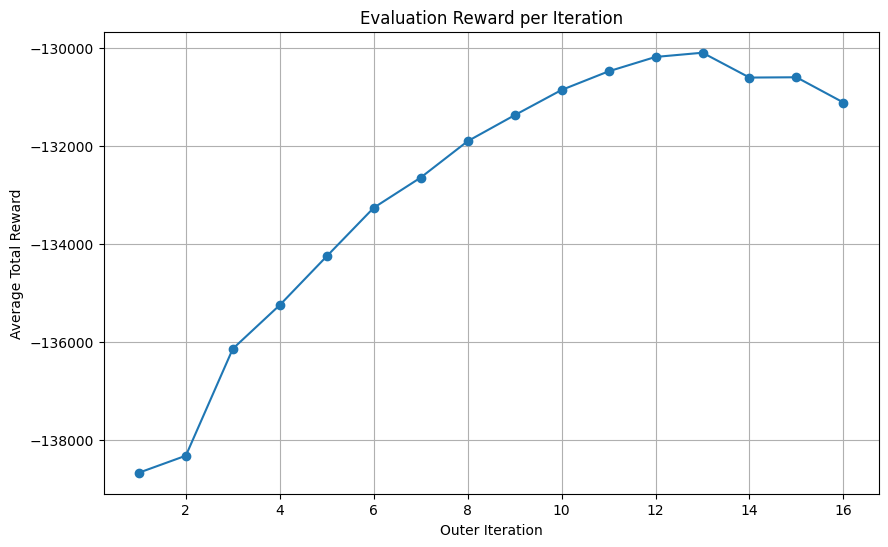

Reward plot saved to results/ms-iclr/pinn-pi/lqr_5d_x0=5.0_sigma=0.01_eval_traj_len=30/reward_plot.png


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

<Figure size 640x480 with 0 Axes>

In [33]:
# 표준 라이브러리
import math
import os
import pickle
import time
from typing import Callable
from os import path, makedirs

# 외부 라이브러리
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import imageio
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd.functional import jacobian
from torch.func import jacrev, vmap
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import pyplot as plt


# 0) 기본 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 결과 저장을 위한 디렉토리 생성



# 데이터 로드
from os import path, makedirs


try:
    matrix = np.load(path.join("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz"))
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found.")
    print("Using random matrices for demonstration.")
    A_np = np.random.randn(5, 5)
    B_np = np.random.randn(5, 5)
    matrix = {'A': A_np, 'B': B_np}


A = torch.from_numpy(matrix['A']).float().to(device)
B = torch.from_numpy(matrix['B']).float().to(device)

print(gym.__file__)

print(A.shape)
print(B.shape)
dimension = 5

B

def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# # diffusion 함수: constant diagonal noise
# def sigma(x, u):
#     # 고정된 대각 행렬 (작은 스케일)
#     S = 0.01 * torch.eye(d, device=device)
#     return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    # affine_u = torch.ones_like(u)
    # cost_u = torch.sum((u-affine_u)**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    
    return -(cost_x + cost_u)


d, m = 5, 5
# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)

# 2) 하이퍼파라미터

d = X_domain.shape[1]
m = U_domain.shape[1]

outer_iters = 15 # 전체 정책 반복 횟수
num_steps = 3000
batch_size = 256
exponent = 0.5

lr_v = 1e-4    # 가치 네트워크 학습률
# sigma = 0.1
sigma = 0.01



# 평가용 하이퍼파라미터
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 50       # 각 궤적의 길이
eval_dt= 0.02
eval_x0_weight = 5.
rho = 0.5      # 할인율
gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

results_dir = f"results/ms-iclr/pinn-pi/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma}_eval_traj_len={eval_num_traj}"
makedirs(results_dir, exist_ok=True)


# # ─── Value Network ───────────────────────────────────────────────────────
# class ValueNet(nn.Module):
#     def __init__(self, S=dimension, hidden=100):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(S, hidden), nn.SiLU(),
#             nn.Linear(hidden, hidden), nn.SiLU(),
#             nn.Linear(hidden, 1)
#         )
#     def forward(self, x):
#         return self.net(x)

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128,128]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            # layers.append(nn.SiLU())
            layers.append(nn.Tanh())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

    
class ValueNet(nn.Module):
    def __init__(self, state_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim, 1, hidden_dims)

    def forward(self, x):
        return self.net(x)

# 4) 보조 함수
def grad(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    return torch.autograd.grad(v_out.sum(), x, create_graph=False)[0]

def grad_and_hess_diag(x, v_func):
    x = x.clone().requires_grad_(True)
    v_out = v_func(x)
    grad_v = torch.autograd.grad(v_out.sum(), x, create_graph=True)[0]
    hess_diag = []
    for i in range(x.shape[1]):
        g_i = grad_v[:, i].sum()
        h_ii = torch.autograd.grad(g_i, x, retain_graph=True)[0][:, i]
        hess_diag.append(h_ii)
    hess_diag = torch.stack(hess_diag, dim=1)
    return grad_v, hess_diag

def laplacain(x,v_func):
    _, hess_diag = grad_and_hess_diag(x, v_func)
    return (hess_diag).sum(dim=-1) # [B]

# 5) 평가 함수
def choose_action(nabla_v, B, U_domain):
    """
    B         : (n, m)  torch.Tensor
    nabla_v   : (n,)    torch.Tensor   — ∇V(x)
    U_domain  : 하한·상한 정의
                • (u_min, u_max)  → 두 개의 스칼라(모든 축 동일 범위)
                • ((m,2) tensor) → 각 축별 [min,max]

    반환값     : (m,) torch.Tensor — 제어 입력 u, U_domain 에서 clip
    """
    single_input = False
    if nabla_v.dim() == 1:
        nabla_v = nabla_v.unsqueeze(0)
        single_input = True

    # 배치-행렬 곱 : (batch,n) @ (n,m) → (batch,m)
    u = -0.5 * torch.matmul(nabla_v, B)

    # 클리핑
    u_min, u_max = -10, 10
    # u = u_max * torch.tanh(u/u_max)
    u = torch.clamp(u, u_min, u_max)

    return u.squeeze(0) if single_input else u

# R = torch.eye(dimension, device=device)
# def choose_action(nabla_v: torch.Tensor,
#                       B: torch.Tensor,
#                       u_max) -> torch.Tensor:
#     """
#     LQR greedy action:
#         u* = argmax_{‖u‖_∞ ≤ u_max} [ -u^T R u + (B^T nabla_v)^T u ]
#            = clip( 0.5 * R^{-1} B^T nabla_v , -u_max, u_max )
#     Args
#       nabla_v: [B, d]  ∇_x v_n(x) for each state in the batch
#       B      : [d, m]  control matrix in dX/dt = A x + B u
#       R      : [m, m]  SPD control weight
#       u_max  : float or [m]-tensor, ∞-norm bound per component
#     Returns
#       u: [B, m]
#     """
#     device = nabla_v.device
#     # rhs = (B^T g) for each batch row g
#     rhs = nabla_v @ B              # [B, m] (since (B^T g) = (g^T B)^T)
#     import pdb; pdb.set_trace()

#     # solve (2 R) u = rhs^T  → u_hat = 0.5 * R^{-1} B^T g
#     R2 = 2.0 * R                   # [m, m]
#     u_hat = torch.linalg.solve(R2, rhs.T).T  # [B, m]

#     # project onto the ∞-box: componentwise clip
#     if not torch.is_tensor(u_max):
#         u_max = torch.tensor(u_max, device=device)
#     u = torch.clamp(u_hat, -u_max, u_max)
#     return u

# def dynamics(state: torch.Tensor):
#     return state

# TODO
# def choose_action_yj(value_net: nn.Module, states: torch.Tensor) -> torch.Tensor:
#     """
#     For training.
#     states: Tensor of shape [B, 2]
#     returns: Tensor of shape [B] with greedy actions
#     """
#     states = states.clone().detach().requires_grad_(True)  # [B, 2]

#     v_s = value_net(states)  # [B, 1]
#     grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]

#     B = states.shape[0]
    
#     def f_row(si, ai):
#         ai = ai.unsqueeze(0)  # shape [1]
#         si = si.unsqueeze(0)  # shape [1, state_dim]
#         fi = (dynamics(si) - si) / eval_dt  # shape: [1, 2]
#         return fi.squeeze(0)  # shape: [2]

#     a = torch.zeros(B, device=device) # [B]
#     # apply row-wise jacobian and extract df[i]/da[i]
#     a_grad = vmap(jacrev(f_row, argnums=1))(states, a)  # shape: [B, 2, 1]
#     #print(a_grad.shape)
#     a_grad = a_grad.squeeze(-1)              # shape: [B, 2]
#     #print(a_grad.shape)
#     u =  torch.sum(a_grad * grad_v, dim=1) / 4 # [B]
#     u_min, u_max = -10, 10
#     return torch.clip(u, u_min, u_max)

def evaluate_policy(sigma, num_traj, traj_len, B, value_net, dt, U_domain):
    print('Start evaluating')
    value_net.eval() # 평가 모드
    dimension = B.shape[0]
    # x = torch.zeros(num_traj, dimension, device=device)
    # x = 0.1 * torch.ones(num_traj, dimension, device=device)
    x = eval_x0_weight * torch.ones(num_traj, dimension, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device) 
    for t in range(traj_len):
        nabla_v = grad(x, value_net)
        u = choose_action(nabla_v, B,  U_domain)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        _sigma = sigma * torch.eye(d, device=device).unsqueeze(0).expand(x.shape[0], d, d)
        diffusion_term = (_sigma @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    value_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward).item(), x_norm_hist

def train_value_parallel(
    value_net: nn.Module,
    opt_v: torch.optim.Optimizer,
    choose_action: Callable,
    epochs: int = 1000,
    batch_size: int = 64,
    device: str = 'cpu',
    exponent: float = 1.0,
    sigma = 0.01,
    b=None
):
    mse_loss = nn.MSELoss()
    # value_net_copy = type(value_net)(d).to(device)
    # value_net_copy.load_state_dict(value_net.state_dict())
    
    start = time.time()

    for epoch in range(1, epochs + 1):
        # 1) 상태 샘플링
        X_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        
        high = 10
        low = -10
        states = (high - low) * torch.rand(batch_size, 5,
                                         device=device) + low
        opt_v.zero_grad()

        # 2) v(s), ∇v(s)
        states.requires_grad_(True)
        v_s = value_net(states)  # [B, 1]
        grad_v = torch.autograd.grad(v_s.sum(), states, create_graph=True)[0]  # [B, 2]
        laplacian = torch.zeros(states.shape[0], device=device)
        for i in range(states.shape[1]):
            # grad_v[:, i] 에 대한 states[:, i] 방향 2차 도함수
            second_deriv = torch.autograd.grad(grad_v[:, i].sum(), states, create_graph=True)[0][:, i]
            laplacian = laplacian + second_deriv
        # trace term: (1/2) * σ^2 * laplacian
        
        trace_term = 0.5 * sigma**2 * laplacian.unsqueeze(1)  # [B, 1]

        # 3) greedy action (벡터화)
        U_domain = torch.tensor([[-10.0]*5, [10.0]*5], device=device)
        actions = choose_action(grad_v, B, U_domain)  # [B]
        
        
        # 4) dynamics
#         next_states = b(states.detach(), actions)  # [B, 2]
        b_tensor =  b(states.detach(), actions)   

        # 5) PDE 잔차
        
        reward = r(states.detach(), actions)
        dot_product = torch.sum(b_tensor * grad_v, dim=1, keepdim=True)  # [B, 1]
        residuals = exponent * v_s - trace_term - dot_product - reward.unsqueeze(1)  # [B, 1]

        # 6) 손실 계산 및 업데이트
        loss = mse_loss(residuals, torch.zeros_like(residuals))
        loss.backward()
        opt_v.step()

        if epoch % 500 == 0:
            elapsed = time.time() - start
            print(f"[Epoch {epoch}/{epochs}] PDE MSE Loss: {loss.item():.4e}  Runtime: {elapsed:.2f}sec")



@torch.no_grad()
def get_trajectories_sac(
    actor: nn.Module,
    b,                      # drift: b(x,u) -> [N,d]
    sigma,                  # diffusion: sigma(x,u) -> [N,d,d]
    r,                      # reward: r(x,u) -> [N]
    num_traj: int,
    traj_len: int,
    dt: float,
    x0: torch.Tensor | None = None,         # [N,d], default zeros
    clamp_X: tuple[float, float] | None = None,  # e.g., (-10., 10.) or None
    gamma: float | None = None,
    q_net: nn.Module | None = None,         # optional: track Q(s,a)
):
    """
    Returns a dict with rollouts (same shapes as your LQR version, plus optional logp/Q):
      X: [T+1, N, d], U: [T, N, m], R: [T, N], G: [N]
      x_norm: [T+1, N], u_norm: [T, N], t: [T+1], t_u: [T]
      If available: logp: [T, N], Q: [T, N]
    """
    device = next(actor.parameters()).device
    # depends on your globals d, m; if you prefer, infer from x0
    d_ = x0.shape[1] if x0 is not None else d
    m_ = m

    # init states
    if x0 is None:
        x = torch.zeros(num_traj, d_, device=device)
    else:
        assert x0.shape == (num_traj, d_)
        x = x0.to(device)

    # allocate
    X    = torch.zeros(traj_len + 1, num_traj, d_, device=device)
    U    = torch.zeros(traj_len,     num_traj, m_, device=device)
    R_t  = torch.zeros(traj_len,     num_traj, device=device)
    LOGP = torch.zeros(traj_len,     num_traj, device=device)  # optional
    Qval = torch.zeros(traj_len,     num_traj, device=device)  # optional

    X[0] = x
    sqrt_dt = math.sqrt(dt)

    # eval mode to freeze any dropout/BN
    was_training = actor.training
    actor.eval()
    if q_net is not None:
        was_training_q = q_net.training
        q_net.eval()

    for t in range(traj_len):
        # sample action from SAC policy
        u, logp = actor.sample(x)          # u: [N,m], logp: [N,1] or [N]
        if logp is None:
            logp = torch.zeros(x.size(0), 1, device=device)

        U[t]   = u
        LOGP[t] = logp.view(-1)

        # reward at current step
        R_t[t] = r(x, u)

        # optional Q tracking
        if q_net is not None:
            Qval[t] = q_net(x, u).view(-1)

        # Euler–Maruyama
        drift = b(x, u)                                    # [N,d]
        S = sigma(x, u)                                    # [N,d,d]
        dW = torch.randn(x.size(0), d_, device=device)     # [N,d]
        x = x + drift * dt + (S @ dW.unsqueeze(-1)).squeeze(-1) * sqrt_dt

        if clamp_X is not None:
            x = torch.clamp(x, clamp_X[0], clamp_X[1])

        X[t+1] = x

    # discounted return per trajectory (optional)
    if gamma is not None:
        weights = (gamma ** torch.arange(traj_len, device=device)).unsqueeze(1)  # [T,1]
        G = (R_t * weights).sum(dim=0)  # [N]
    else:
        G = R_t.sum(dim=0)

    # convenience extras + time axes
    x_norm = X.norm(dim=2)            # [T+1, N]
    u_norm = U.norm(dim=2)            # [T, N]
    t = torch.arange(traj_len + 1, device=device) * dt
    t_u = torch.arange(traj_len, device=device) * dt

    # restore modes
    if was_training:
        actor.train()
    if q_net is not None and was_training_q:
        q_net.train()

    out = {
        "X": X, "U": U, "R": R_t, "G": G,
        "x_norm": x_norm, "u_norm": u_norm,
        "t": t, "t_u": t_u
    }
    # attach optional tracks only if meaningful
    if LOGP.abs().sum() > 0:
        out["logp"] = LOGP
    if q_net is not None:
        out["Q"] = Qval
    return out


# ===================== Plotting helper (SAC-friendly) =====================
def plot_trajectories_sac(traj: dict,
                          state_idxs=None,    # e.g., [0,1,2]; None → up to 3
                          action_idxs=None,   # e.g., [0,1];  None → up to 2
                          n_samples: int = 5,
                          title_prefix: str = "SAC rollout",
                          savepath: str | None = None):
    """
    Plots:
      1) selected state components (few sample trajectories + batch mean)
      2) selected action components (few samples + batch mean)
      3) state norm (mean ± std)
      4) action norm (mean ± std) with reward mean (twin axis)
      5) optional: −log π(a|x) mean (approx entropy) and/or Q(s,a) mean (twin)
    """
    import matplotlib.pyplot as plt

    def to_np(x): return x.detach().cpu().numpy()

    X = to_np(traj["X"])        # [T+1, N, d]
    U = to_np(traj["U"])        # [T, N, m]
    R = to_np(traj["R"])        # [T, N]
    t = to_np(traj["t"])        # [T+1]
    t_u = to_np(traj["t_u"])    # [T]
    x_norm = to_np(traj["x_norm"])  # [T+1, N]
    u_norm = to_np(traj["u_norm"])  # [T, N]

    has_logp = "logp" in traj
    has_Q    = "Q" in traj
    LOGP = to_np(traj["logp"]) if has_logp else None       # [T,N]
    QVAL = to_np(traj["Q"]) if has_Q else None             # [T,N]

    T_plus_1, N, d = X.shape
    T, _, m = U.shape

    if state_idxs is None:
        state_idxs = list(range(min(d, 3)))
    if action_idxs is None:
        action_idxs = list(range(min(m, 2)))

    sample_ids = np.linspace(0, N-1, num=min(N, n_samples), dtype=int)

    n_rows = 4 + int(has_logp or has_Q)
    fig, axes = plt.subplots(n_rows, 1, figsize=(10, 3*n_rows), sharex=False)

    # 1) state components
    ax = axes[0]
    for i in state_idxs:
        ax.plot(t, X[:, :, i].mean(axis=1), label=f"x[{i}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t, X[:, sid, i], alpha=0.25)
    ax.set_title(f"{title_prefix} — state components")
    ax.set_xlabel("time")
    ax.set_ylabel("x_i")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 2) action components
    ax = axes[1]
    for j in action_idxs:
        ax.plot(t_u, U[:, :, j].mean(axis=1), label=f"u[{j}] mean", linewidth=2)
        for sid in sample_ids:
            ax.plot(t_u, U[:, sid, j], alpha=0.25)
    ax.set_title("action components")
    ax.set_xlabel("time")
    ax.set_ylabel("u_j")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncols=2)

    # 3) state norm
    ax = axes[2]
    mu = x_norm.mean(axis=1); sd = x_norm.std(axis=1)
    ax.plot(t, mu, label="‖x‖ mean", linewidth=2)
    ax.fill_between(t, mu - sd, mu + sd, alpha=0.2)
    ax.set_title("state norm (mean ± std)")
    ax.set_xlabel("time")
    ax.set_ylabel("‖x‖")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")

    # 4) action norm + reward (twin)
    ax = axes[3]
    mu = u_norm.mean(axis=1); sd = u_norm.std(axis=1)
    ax.plot(t_u, mu, label="‖u‖ mean", linewidth=2)
    ax.fill_between(t_u, mu - sd, mu + sd, alpha=0.2)
    ax.set_xlabel("time")
    ax.set_ylabel("‖u‖")
    ax.set_title("action norm and reward")
    ax.grid(True, alpha=0.3)
    ax2 = ax.twinx()
    r_mu = R.mean(axis=1); r_sd = R.std(axis=1)
    ax2.plot(t_u, r_mu, linestyle="--", label="reward mean")
    ax2.fill_between(t_u, r_mu - r_sd, r_mu + r_sd, alpha=0.15)
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc="upper right")
    ax2.set_ylabel("r_t")

    # 5) optional entropy proxy and/or Q
    if n_rows > 4:
        ax = axes[4]
        plotted = False
        if has_logp:
            neg_logp_mu = (-LOGP).mean(axis=1)
            neg_logp_sd = (-LOGP).std(axis=1)
            ax.plot(t_u, neg_logp_mu, label="−log π(a|x) mean", linewidth=2)
            ax.fill_between(t_u, neg_logp_mu - neg_logp_sd, neg_logp_mu + neg_logp_sd, alpha=0.2)
            plotted = True
        if has_Q:
            ax2 = ax.twinx()
            q_mu = QVAL.mean(axis=1); q_sd = QVAL.std(axis=1)
            ax2.plot(t_u, q_mu, linestyle="--", label="Q(s,a) mean")
            ax2.fill_between(t_u, q_mu - q_sd, q_mu + q_sd, alpha=0.15)
            # combine legends
            L1, L1n = ax.get_legend_handles_labels()
            L2, L2n = ax2.get_legend_handles_labels()
            ax2.legend(L1 + L2, L1n + L2n, loc="upper right")
        if plotted:
            ax.set_title("entropy / Q tracks")
            ax.set_xlabel("time")
            ax.set_ylabel("−log π")
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=150)
    plt.show()



value_net = ValueNet(d).to(device)
opt_v     = optim.Adam(value_net.parameters(), lr=lr_v)

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)
print(eval_reward)

# ─── Main Loop: Approximate Policy Iteration ───────────────────────────────
start = time.time()
total_reward = []
total_step = []

eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                         eval_traj_len, B, value_net,
                                         eval_dt, U_domain)

print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
total_reward.append(eval_reward)

for it in range(outer_iters):
    opt_v.zero_grad()

    # 가치함수 업데이트
    train_value_parallel( value_net=value_net,
                            opt_v=opt_v,
                            choose_action = choose_action,
                            epochs=num_steps, batch_size=batch_size, device=device,
                            exponent=exponent, sigma = sigma,  b=b)
    elapsed = time.time() - start
    print(f"[Iter {it+1}/{outer_iters}] Runtime: {elapsed:.2f}sec")
    print("Evaluation start")

    opt_v.zero_grad()
    eval_reward, x_history = evaluate_policy(sigma, eval_num_traj, 
                                             eval_traj_len, B, value_net,
                                             eval_dt, U_domain)

    print(f'Estimated Value: {eval_reward} Runtime: {time.time() - start}')
    total_reward.append(eval_reward)


with open(os.path.join(results_dir, 'Value.pkl'), 'wb') as f:
    pickle.dump(total_reward, f)




# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(total_reward) + 1), total_reward, marker='o')
plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
plt.show()
plot_file = path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

# random x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=torch.randn(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_random_x0.png"
)



# eval x_0 trajectory
traj = get_trajectories_sac(
    actor=actor,
    b=b, sigma=sigma, r=r,
    num_traj=eval_num_traj,
    traj_len=eval_traj_len,
    dt=eval_dt,
    x0=eval_x0_weight * torch.ones(eval_num_traj, d, device=device),
    clamp_X=X_domain,
    gamma=gamma,        # or None if you want undiscounted step sum
    q_net=q             # optional; pass None to skip
)
plot_trajectories_sac(
    traj,
    state_idxs=[0,1,2],
    action_idxs=[0,1],
    n_samples=5,
    title_prefix="SAC rollout",
    savepath=f"{results_dir}/rollout_eval_x0.png"
)


### X_0 = 1, sigma = 0.01, eval_traj_len = 50

0.9900498337491681
Start evaluating
tensor(-13651.5928)
Step 0: Reward -1.529 
Step 100: Reward -2.424 
Step 200: Reward -384.710 
Start evaluating
Evaluation Average Reward: -1.3658e+04 Time: 0.86s
Start evaluating
Evaluation Average Reward: -1.4496e+04 Time: 1.23s
Start evaluating
Evaluation Average Reward: -1.4602e+04 Time: 1.58s
Start evaluating
Evaluation Average Reward: -1.3323e+04 Time: 1.94s
Start evaluating
Evaluation Average Reward: -9.3727e+03 Time: 2.33s
Step 300: Reward -116.663 
Start evaluating
Evaluation Average Reward: -7.6332e+03 Time: 2.70s
Start evaluating
Evaluation Average Reward: -7.4056e+03 Time: 3.05s
Start evaluating
Evaluation Average Reward: -5.8060e+03 Time: 3.45s
Start evaluating
Evaluation Average Reward: -6.0276e+03 Time: 3.91s
Start evaluating
Evaluation Average Reward: -5.7449e+03 Time: 4.26s
Start evaluating
Evaluation Average Reward: -5.3780e+03 Time: 4.62s
Start evaluating
Evaluation Average Reward: -5.3930e+03 Time: 4.94s
Start evaluating
Evaluatio

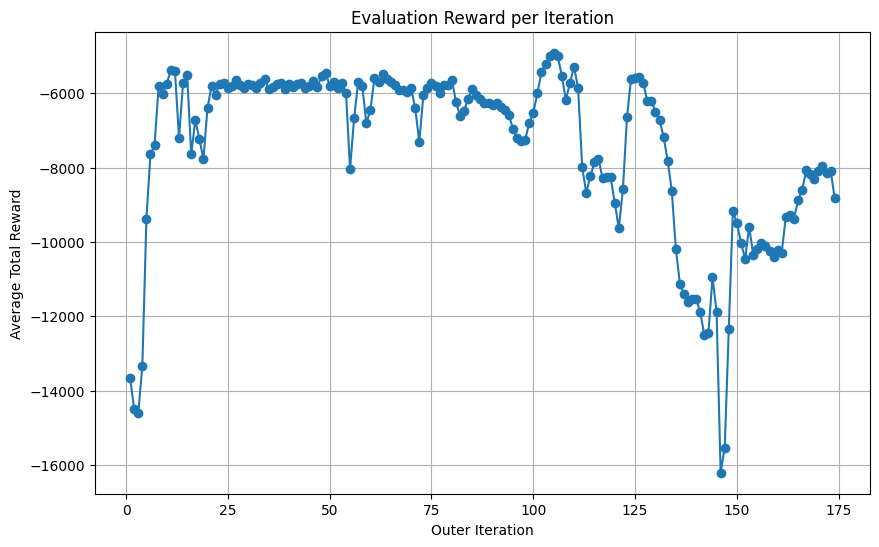

Reward plot saved to results/ms-iclr/sac/lqr_5d_x0=1_sigma=0p01_eval_traj_len=50/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs


# 환경
sigma_weight = 0.01

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 50       # 각 궤적의 길이
eval_x0_weight = 1.

alpha = 0.2  # 온도 계수
lam = 0.1      # 엔트로피 가중치
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1



# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

# 결과 저장을 위한 디렉토리 생성
results_dir = f"results/ms-iclr/sac/lqr_{m}d_x0={eval_x0_weight}_sigma={sigma_weight}_eval_traj_len={eval_traj_len}"
makedirs(results_dir, exist_ok=True)


device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = sigma_weight * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================


actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0



print(gamma)

@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = eval_x0_weight * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)


# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
# plt.yscale('linear')
plt.yscale('linear')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### x_0 = 0, sigma = 0.1, eval_traj_len = 100

0.9900498337491681
Start evaluating
tensor(-12983.3779)
Step 0: Reward -1.454 
Step 100: Reward -6.038 
Step 200: Reward -198.812 
Start evaluating
Evaluation Average Reward: -1.2784e+04 Time: 0.93s
Start evaluating
Evaluation Average Reward: -1.2184e+04 Time: 1.29s
Start evaluating
Evaluation Average Reward: -1.1074e+04 Time: 1.72s
Start evaluating
Evaluation Average Reward: -9.4921e+03 Time: 2.12s
Start evaluating
Evaluation Average Reward: -7.1752e+03 Time: 2.51s
Step 300: Reward -204.015 
Start evaluating
Evaluation Average Reward: -4.3715e+03 Time: 2.87s
Start evaluating
Evaluation Average Reward: -2.7014e+03 Time: 3.24s
Start evaluating
Evaluation Average Reward: -1.3257e+03 Time: 3.60s
Start evaluating
Evaluation Average Reward: -8.2003e+02 Time: 3.97s
Start evaluating
Evaluation Average Reward: -5.2005e+02 Time: 4.40s
Start evaluating
Evaluation Average Reward: -2.6574e+02 Time: 4.83s
Start evaluating
Evaluation Average Reward: -3.1875e+02 Time: 5.20s
Start evaluating
Evaluatio

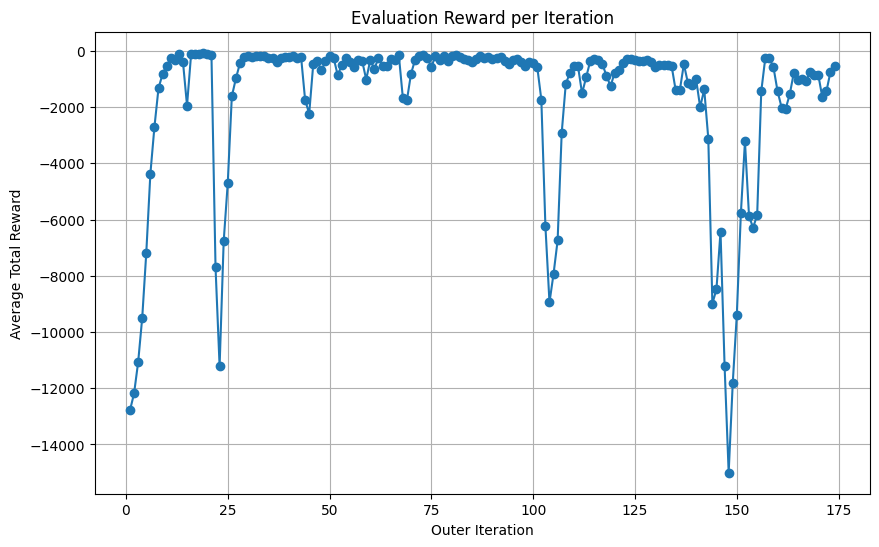

Reward plot saved to results/ms-iclr/sac/lqr_5d_x0=1_sigma=0p1_eval_traj_len=100/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [28]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_x0=0_sigma=0p1_eval_traj_len=100"
makedirs(results_dir, exist_ok=True)

sigma_weight = 0.1

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
eval_x0_weight = 0.

alpha = 0.2  # 온도 계수
lam = 0.1      # 엔트로피 가중치
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1



# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = sigma_weight * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================


actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0



print(gamma)

@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = eval_x0_weight * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)


# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
# plt.yscale('linear')
plt.yscale('linear')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### x_0 = 1, sigma = 0.01, eval_traj_len = 100

0.9900498337491681
Start evaluating
tensor(-86709.7344)
Step 0: Reward -2.501 
Step 100: Reward -1.173 
Step 200: Reward -114.550 
Start evaluating
Evaluation Average Reward: -1.1204e+05 Time: 0.73s
Start evaluating
Evaluation Average Reward: -1.6304e+05 Time: 1.06s
Start evaluating
Evaluation Average Reward: -2.0493e+05 Time: 1.40s
Start evaluating
Evaluation Average Reward: -2.1339e+05 Time: 1.72s
Start evaluating
Evaluation Average Reward: -1.7787e+05 Time: 2.04s
Step 300: Reward -227.881 
Start evaluating
Evaluation Average Reward: -1.3423e+05 Time: 2.35s
Start evaluating
Evaluation Average Reward: -1.1538e+05 Time: 2.66s
Start evaluating
Evaluation Average Reward: -8.2479e+04 Time: 2.97s
Start evaluating
Evaluation Average Reward: -6.7663e+04 Time: 3.26s
Start evaluating
Evaluation Average Reward: -5.2891e+04 Time: 3.58s
Start evaluating
Evaluation Average Reward: -4.4582e+04 Time: 3.88s
Start evaluating
Evaluation Average Reward: -5.4896e+04 Time: 4.20s
Start evaluating
Evaluatio

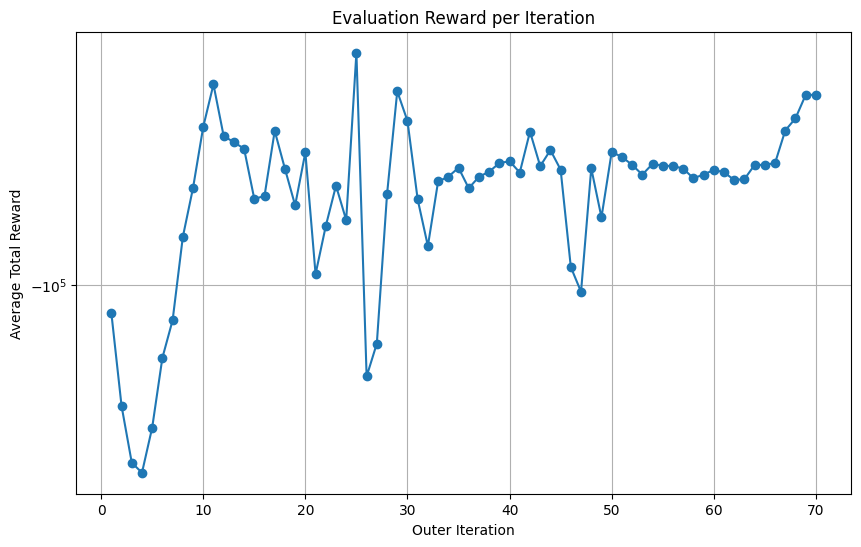

Reward plot saved to results/ms-iclr/sac/lqr_5d_x0=1/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [25]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_x0=1"
makedirs(results_dir, exist_ok=True)


# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
eval_x0_weight = 1

alpha = 0.2  # 온도 계수
lam = 0.1      # 엔트로피 가중치
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1


# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)


# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))


# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================


actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0



print(gamma)

@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = eval_x0_weight * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist


avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)


# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")


# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

from matplotlib import pyplot as plt

print(len(reward_history))
# reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
# plt.yscale('linear')
plt.yscale('linear')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

Loaded reward history


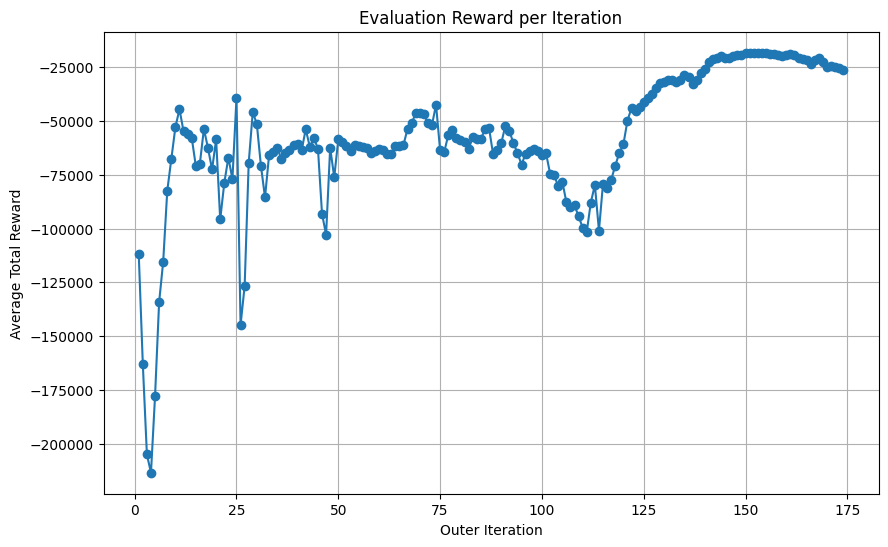

Reward plot saved to results/ms-iclr/sac/lqr_5d_x0=1/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [27]:

reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

# reward_history = reward_history[:70]

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
# plt.yscale('linear')
plt.yscale('linear')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

### f

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
from time import time
import math
import os
from os import makedirs

In [2]:
# ============================
# 1. 환경 dynamics 정의
# ============================

# 상태-행동 차원 설정
d = 5  # 상태 차원
m = 5  # 행동 차원

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 결과 저장을 위한 디렉토리 생성
results_dir = "results/ms-iclr/sac/lqr_5d_update_every"
makedirs(results_dir, exist_ok=True)

# 데이터 로드
try:
    matrix = np.load("gym_lqr/gym_lqr/envs/data/matrix_5d_5d.npz")
    A_np, B_np = matrix["A"], matrix["B"]
except FileNotFoundError:
    print("Error: matrix_5d_5d.npz not found. Using random matrices.")
    A_np = np.random.randn(d, d)
    B_np = np.random.randn(d, m)

A = torch.from_numpy(A_np).float().to(device)
B = torch.from_numpy(B_np).float().to(device)

# drift 함수: b(x,u) = Ax + uB
def b(x, u):
    # x: [B, d], u: [B, m]
    return x @ A.T + u @ B

# diffusion 함수: constant diagonal noise
def sigma(x, u):
    # 고정된 대각 행렬 (작은 스케일)
    S = 0.01 * torch.eye(d, device=device)
    return S.unsqueeze(0).expand(x.shape[0], d, d)

# reward 함수 (running cost): r(x,u) = -5||x||^2 - ||u||^2
def r(x, u):
    cost_x = 5.0 * torch.sum(x**2, dim=1)
    cost_u = torch.sum(u**2, dim=1)
    return -(cost_x + cost_u)

# 도메인 클리핑
X_min, X_max = X_domain = torch.tensor([[-10.0]*d, [10.0]*d], device=device)
U_min, U_max = U_domain = torch.tensor([[-10.0]*m, [10.0]*m], device=device)


In [3]:
# ============================
# 2. SAC 구성 요소 정의
# ============================

class MLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[256,256]):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Actor: state -> Gaussian(mean, log_std)
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256], log_std_min=-20, log_std_max=2):
        super().__init__()
        self.net = MLP(state_dim, 2*action_dim, hidden_dims)
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max

    def forward(self, x):
        out = self.net(x)
        mu, log_std = torch.chunk(out, 2, dim=-1)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, x, _eps=1e-9):
        mu, std = self.forward(x)
        eps = torch.randn_like(mu)
        action = mu + eps * std
        action_tanh = U_max[0] * torch.tanh(action)
        log_prob = -0.5 * ((eps**2) + np.log(2*torch.pi))-torch.log((U_max[0] * torch.abs(mu)) + _eps)-torch.log(1-(action_tanh/U_max[0])**2 + _eps)
        log_prob = log_prob.sum(dim=-1, keepdim=True)
        # 액션을 도메인에 맞춰 tanh 스케일링
        return action_tanh, log_prob

# Q-network: state, action -> Q-value
class QNet(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dims=[256,256]):
        super().__init__()
        self.net = MLP(state_dim+action_dim, 1, hidden_dims)

    def forward(self, x, u):
        xu = torch.cat([x, u], dim=-1)
        return self.net(xu)

# Replay buffer
def soft_update(net, target_net, tau):
    for p, tp in zip(net.parameters(), target_net.parameters()):
        tp.data.copy_(tau * p.data + (1 - tau) * tp.data)

class ReplayBuffer:
    def __init__(self, max_size=1_000_000):
        self.buffer = deque(maxlen=max_size)

    def add(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state = zip(*batch)
        return (torch.stack(state), torch.stack(action),
                torch.tensor(reward, device=device).unsqueeze(1),
                torch.stack(next_state))

In [4]:
# ============================
# 3. 학습 파라미터 및 네트워크 초기화
# ============================

# 하이퍼파라미터
rho = 0.5
eval_dt= 0.02
tau = eval_dt
gamma = math.exp(-rho * eval_dt)
# gamma = 0.99
alpha = 0.2  # 온도 계수
lr = 3e-4
batch_size = 256
num_steps = 2000
start_steps = 200
update_after = 200
update_every = 1

actor = Actor(d, m).to(device)
q = QNet(d, m).to(device)
q_target = QNet(d, m).to(device)

# 타겟 네트워크 초기화
q_target.load_state_dict(q.state_dict())

# Optimizers
actor_opt = optim.Adam(actor.parameters(), lr=lr)
q_opt = optim.Adam(q.parameters(), lr=lr)

# Replay buffer 생성
replay = ReplayBuffer()

# 초기 상태 샘플링 함수
def sample_initial_state(batch_size=1):
    x0 = torch.zeros(batch_size, d, device=device)
    return x0

# 평가용 하이퍼파라미터\
# rho = 0.5      # 할인율
lam = 0.1      # 엔트로피 가중치
eval_num_traj = 30        # 평가 시뮬레이션 궤적 수
eval_traj_len = 100       # 각 궤적의 길이
# eval_dt = 0.005            # 시뮬레이션 시간 스텝
# gamma = math.exp(-rho * eval_dt) # 스텝마다의 할인율

print(gamma)

0.9900498337491681


In [5]:
@torch.no_grad()
def evaluate_policy(policy_net, num_traj, traj_len, dt):
    print('Start evaluating')
    policy_net.eval() # 평가 모드
    total_rewards = []
    

    # 초기 상태는 0 벡터로 시작
    # x = torch.zeros(num_traj, d, device=device)
    x = 0.1 * torch.ones(num_traj, d, device=device)
    episode_reward = torch.zeros(num_traj, device=device)
    x_norm_hist = torch.zeros(num_traj, traj_len, device = device)
    
    for t in range(traj_len):
        # sample from policy
        #print(f'state shape: {x.shape}')
        u = policy_net.sample(x)[0].squeeze(1) # [num_traj, m]
        #print(u.shape)
        
        # 보상 계산
        current_reward = r(x, u) # [B]
        episode_reward += current_reward * (gamma ** t) # [B]
        
        # 다음 상태 계산 (Euler-Maruyama)
        drift_term = b(x, u) # [num_traj, d]
        diffusion_term = (sigma(x, u) @ torch.randn(num_traj, d, 1, device=device)).squeeze(2)
        #print(f'diffusion term shape: {diffusion_term.shape}')

        #print(x.shape, drift_term.shape, diffusion_term.shape)
        x = x + drift_term * dt + diffusion_term * np.sqrt(dt)
        #x = torch.clamp(x, X_domain[0][0], X_domain[1][0])
        x_norm_hist[:,t] = torch.norm(x, dim=1)

    x_norm_hist = torch.mean(x_norm_hist, dim=0) 
    policy_net.train() # 다시 학습 모드로
    return torch.mean(episode_reward), x_norm_hist

In [7]:
avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)

print(avg_reward)

Start evaluating
tensor(-13173.7139)


In [8]:
# ============================
# 4. 메인 학습 루프
# ============================

torch.autograd.set_detect_anomaly(True)
reward_history = []
x_norm_hist_hist = torch.zeros(num_steps, eval_traj_len, device=device)
start = time()
state = sample_initial_state()
for t in range(0, num_steps):
    # 1) 행동 선택
    if t < start_steps:
        action = torch.rand(1, m, device=device) * 2 - 1  # 탐사용 랜덤 액션
    else:
        action, _ = actor.sample(state)

    # 2) 환경 전이 (Euler-Maruyama integration)
    dt = eval_dt
    drift = b(state, action) * dt
    noise = sigma(state, action)
    dW = torch.randn_like(state) * np.sqrt(dt)
    next_state = state + drift + (noise @ dW.unsqueeze(-1)).squeeze(-1)
    # 도메인 클리핑
    next_state = torch.max(torch.min(next_state, X_max), X_min)

    # 3) 보상 계산
    reward = r(state, action)

    # 4) 리플레이 버퍼에 저장
    replay.add((state.squeeze(0).detach(), action.squeeze(0).detach(), reward, next_state.squeeze(0).detach()))
    state = next_state.detach()

    # 5) 네트워크 업데이트
    updated = False
    if t >= update_after and len(replay.buffer) >= batch_size:
        for _ in range(update_every):
            s, u, rew, s2 = replay.sample(batch_size)

            # 타겟 Q 값 계산
            with torch.no_grad():
                a2, logp2 = actor.sample(s2)
                q_t = q_target(s2, a2)
                y = rew + gamma * (q_t - alpha * logp2)

            # Q 함수 업데이트
            q_loss = nn.MSELoss()(q(s, u), y)
            q_opt.zero_grad(); q_loss.backward(); q_opt.step()

            # 정책 업데이트
            a_hat, logp_hat = actor.sample(s)
            q_val = q(s, a_hat)
            actor_loss = (alpha * logp_hat - q_val).mean()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # 타겟 네트워크 소프트 업데이트
            soft_update(q, q_target, tau)

        updated = True

    # 에피소드 재시작: 상태가 너무 커지면 초기화
    if torch.norm(state) > 10:
        state = sample_initial_state()

    if t % 10 == 0 and updated:
        avg_reward, x_norm_hist = evaluate_policy(actor, eval_num_traj, eval_traj_len, eval_dt)
        avg_reward = avg_reward.item()
        reward_history.append(avg_reward)
        x_norm_hist_hist[t, :] = x_norm_hist
        print(f"Evaluation Average Reward: {avg_reward:.4e} Time: {time() - start:.2f}s")

    # 로그 출력
    if t % 100 == 0:
        print(f"Step {t}: Reward {reward.item():.3f} ")

print("Training finished.")

Step 0: Reward -1.000 
Step 100: Reward -3.004 
Step 200: Reward -277.016 
Start evaluating
Evaluation Average Reward: -1.2259e+04 Time: 0.89s
Start evaluating
Evaluation Average Reward: -1.1336e+04 Time: 1.24s
Start evaluating
Evaluation Average Reward: -1.1697e+04 Time: 1.63s
Start evaluating
Evaluation Average Reward: -1.0726e+04 Time: 2.10s
Start evaluating
Evaluation Average Reward: -9.4932e+03 Time: 2.45s
Step 300: Reward -42.429 
Start evaluating
Evaluation Average Reward: -4.7602e+03 Time: 2.82s
Start evaluating
Evaluation Average Reward: -1.5579e+03 Time: 3.19s
Start evaluating
Evaluation Average Reward: -7.9056e+02 Time: 3.64s
Start evaluating
Evaluation Average Reward: -3.9238e+02 Time: 4.05s
Start evaluating
Evaluation Average Reward: -3.2396e+02 Time: 4.39s
Start evaluating
Evaluation Average Reward: -3.3609e+03 Time: 4.77s
Start evaluating
Evaluation Average Reward: -1.1154e+03 Time: 5.13s
Start evaluating
Evaluation Average Reward: -5.0518e+02 Time: 5.49s
Start evaluatin

In [9]:
# 보상 기록 저장
reward_file = os.path.join(results_dir, "reward_history.npy")
np.save(reward_file, np.array(reward_history))
print(f"Reward history saved to {reward_file}")

Reward history saved to results/ms-iclr/sac/lqr_5d_update_every/reward_history.npy


In [10]:
reward_file = os.path.join(results_dir, "reward_history.npy")
reward_history = np.load(reward_file)
print("Loaded reward history")

Loaded reward history


70


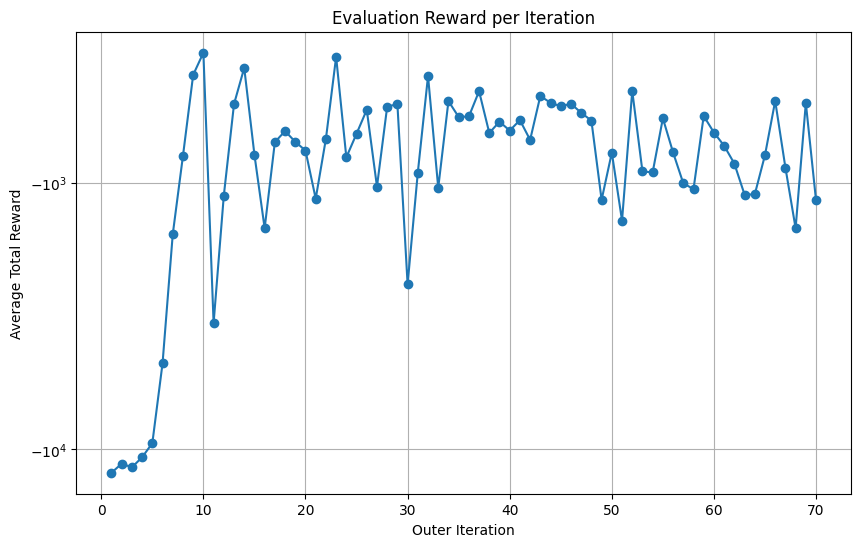

Reward plot saved to results/ms-iclr/sac/lqr_5d_update_every/reward_plot.png


<Figure size 640x480 with 0 Axes>

In [24]:
from matplotlib import pyplot as plt

print(len(reward_history))
reward_history = reward_history[:70]
# 보상 그래프 시각화 및 저장
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(reward_history) + 1), reward_history, marker='o')

plt.title("Evaluation Reward per Iteration")
plt.xlabel("Outer Iteration")
plt.ylabel("Average Total Reward")
plt.grid(True)
# plt.yscale('linear')
plt.yscale('symlog')

plt.show()
plot_file = os.path.join(results_dir, "reward_plot.png")
plt.savefig(plot_file)
print(f"Reward plot saved to {plot_file}")

In [ ]:


# 모델 체크포인트 저장
v_net_file = path.join(results_dir, "v_net.pth")
pi_net_file = path.join(results_dir, "pi_net.pth")
torch.save(v_net.state_dict(), v_net_file)
torch.save(pi_net.state_dict(), pi_net_file)
print(f"Value network saved to {v_net_file}")
print(f"Policy network saved to {pi_net_file}")





In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, eval_traj_len + 1), x_norm_hist_hist[-1].cpu().numpy(), linewidth=1.0)
plt.title("The last x norm trajectory")
plt.xlabel("time step")
plt.ylabel("x norm trajectory")
plt.grid(True)
plot_file = path.join(results_dir, "last_x_norm_trajectory.png")
plt.savefig(plot_file)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, outer_iters + 1), x_norm_hist_hist[:, -1].cpu().numpy(), linewidth=1.0)
plt.title("Final x norm")
plt.xlabel("Outer Iteration")
plt.ylabel("Final x norm")
plt.grid(True)
plot_file = path.join(results_dir, "Final_x_norm.png")
plt.savefig(plot_file)
plt.show()